In [17]:
import nistats
import nibabel as nib
import nilearn
from nilearn import image
#from nistats.first_level_model import FirstLevelModel
#from nistats.second_level_model import SecondLevelModel
#from nistats.thresholding import map_threshold
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map
from nilearn import plotting
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import pickle as pkl
from plotting_utils_ses_sstmsit import *
import scipy
from scipy.stats import mode
import seaborn as sns
import statsmodels.api as sm
import statsmodels

# t1w background image template
# mni09c = '/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'
mni09c = '/home/scotti/projects/3t_7t_sst_comparison/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii'

%matplotlib inline

In [18]:
def merge_pos_neg(pos, neg):
    return image.math_img('pos-neg', pos=pos, neg=neg)

def get_second_level_zmap(first_level_contrast, second_level_contrast, fwhm='1p5', model_n=0, thresholding=None, threshold_z=3.1, hp=False,
                          base_dir='../derivatives/glm_feat_hp/group_level_model/ses-sstmsit/task-sst',
                          from_working_dir=False, 
                          flame='1'):
    
    # Look-up dictionaries
    if model_n == 0:
        first_level_copes = {'fs': 0,
                             'ss': 1,
                             'go': 2,
                             'fs-go': 3,
                             'fs-ss': 4,
                             'ss-go': 5
                             }

        second_level_copes = {'intercept': 1,
                              '-intercept': 2}
    elif model_n == 1:
        first_level_copes = {'response_left': 0,
                             'response_right': 1,
                             'left-right': 2}

        second_level_copes = {'intercept': 1,
                              '-intercept': 2}
    
    cope1 = first_level_copes[first_level_contrast]
    cope2 = second_level_copes[second_level_contrast]
    
    if hp:
        model_suffix = '_hp'
    else:
        model_suffix = ''

    if thresholding is None or thresholding == 'fdr':
        if from_working_dir:
            nii = nib.load(f'../processing/nipype_workflow_folders/feat_level3_sstmsit_hp/_contrast_n_{cope1}_fwhm_1p5_model_n_{model_n}/_run_mode_flame{flame}/flameo/stats/zstat{cope2}.nii.gz')
        else:
            nii = nib.load(os.path.join(base_dir, f'model-{model_n}{model_suffix}/model-{model_n}{model_suffix}/model-{model_n}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2}_flame-{flame}_desc-zstat.nii.gz'))
        
        if thresholding is None:
            threshold = 0
        else:
            _, threshold = threshold_stats_img(nii, alpha=0.05, height_control='fdr')
            
    elif thresholding == 'fwer' or thresholding == 'cluster':
        
        # if from_working_dir:
        #     nii = nib.load(f'../processing/nipype_workflow_folders/feat_level3_rlsat/_contrast_n_{cope1}_fwhm_1p5_model_n_{model_n}/_run_mode_{run_mode}/flameo/stats/zstat{cope2}.nii.gz')        
        nii_pos = nib.load(os.path.join(base_dir, f'model-{model_n}{model_suffix}/model-{model_n}{model_suffix}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2}_flame-{flame}_desc-zstat_voxelthreshold-{threshold_z}.nii.gz'))
        nii_neg = nib.load(os.path.join(base_dir, f'model-{model_n}/model-{model_n}{model_suffix}/model-{model_n}_fwhm-{fwhm}_subjectlevelcontrast-{cope1}_grouplevelcontrast-{cope2+1}_flame-{flame}_desc-zstat_voxelthreshold-{threshold_z}.nii.gz'))

        nii = merge_pos_neg(nii_pos, nii_neg)
        threshold = np.min(nii_pos.get_fdata())
        

    return nii, threshold

def plot_4x4(z_map, n_cuts=16, display_mode='z', **kwargs):
    cols = rows = int(np.sqrt(n_cuts))
    
    gridspec = dict(hspace=0.0, wspace=0.0, width_ratios=[1, 1, 1, 1.3])
    f, axes = plt.subplots(4, 4, gridspec_kw=gridspec)
    ax = axes.ravel()
    
    cut_coords = nilearn.plotting.find_cut_slices(z_map, direction=display_mode, n_cuts=n_cuts)
    
    if(z_map.get_fdata().sum() == 0):
        print('No non-zero z-values, nothing to plot!')
        return f, ax
    
    for i in range(n_cuts):
        # plot colorbar in right-most column
        if ((i+1)/cols % cols) == int(((i+1)/cols % cols)):
            colorbar = True
        else:
            colorbar = False
        
        if i == 0 and 'title' in kwargs.keys():
            title = kwargs.pop('title')
        else:
            title = None
        
        plotting.plot_stat_map(z_map, display_mode=display_mode, colorbar=colorbar, title=title,
                               cut_coords=[cut_coords[i]], figure=f, axes=ax[i], **kwargs)
        
    f.set_size_inches(15,15)
    return f, ax

# aron_3T

In [10]:
dataset = 'aron_3T'
base_dir = f'../derivatives/glm_feat_sst_roi/group_level_model/{dataset}'
fwhm = '1p5'

## FS-Go

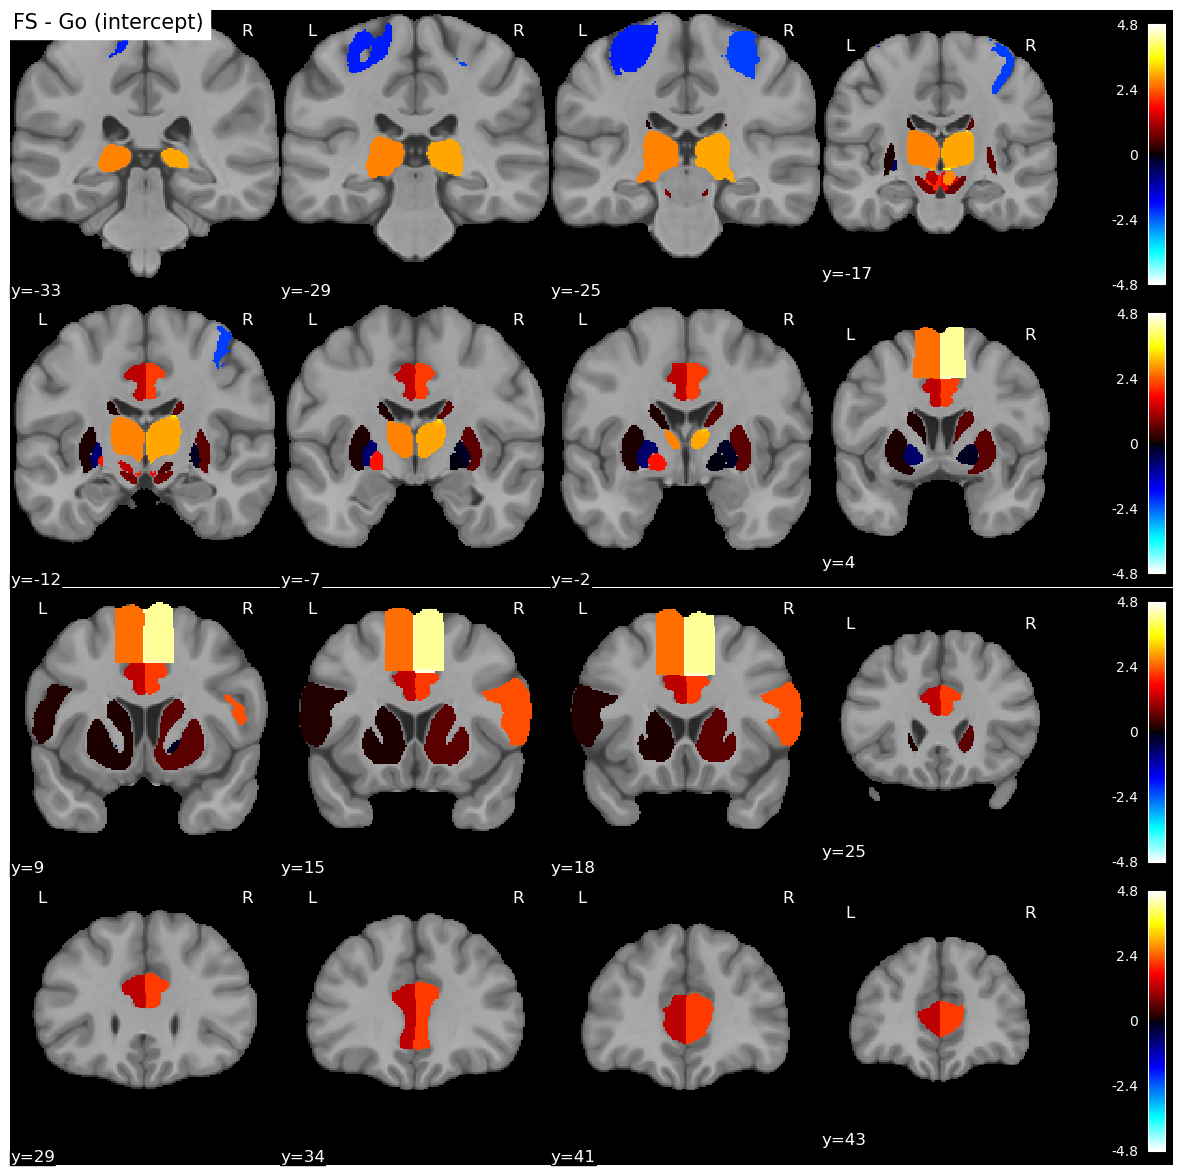

In [11]:
fs_go_intercept, threshold = get_second_level_zmap('fs-go', 'intercept', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False,  base_dir=base_dir, flame='12')
f, ax = plot_4x4(fs_go_intercept, display_mode='y', threshold=0, bg_img=mni09c, title='FS - Go (intercept)')

# extract z stat from ROI

In [12]:
def get_mni_roi_masks():
    
    masks = sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/sourcedata/useful_masks_mni09c1mm/*'))
    
    return masks


In [13]:
these_masks = get_mni_roi_masks()
contrasts = ['fs-go','fs-ss','ss-go']

contrast = []
roi = []
zstat = []
hemi = []
for this_contrast in contrasts:
    intercept, threshold = get_second_level_zmap(this_contrast, 'intercept', fwhm=fwhm, thresholding=None,model_n=0,from_working_dir=False,  base_dir=base_dir, flame='12')
    intercept = intercept.get_fdata()
    print(this_contrast)
    for this_mask in these_masks:

        load_mask = nib.load(this_mask).get_fdata()
        this_roi = this_mask.split('_label-')[-1].split('.')[0].split('-')[0]
        this_hemi = this_mask.split('_label-')[-1].split('.')[0].split('-')[1]
#         print(this_roi)

        roi_z = intercept[:,:,:][load_mask>0.5]

        contrast.append(this_contrast)
        roi.append(this_roi)
        zstat.append(float(mode(roi_z)[0]))
#         zstat.append(roi_z.mean())
        hemi.append(this_hemi)
        
zstat_results = pd.DataFrame(list(zip(contrast,roi,hemi,zstat)),columns=['contrast','roi','hemi','zstat'])
zstat_results['pstat'] = scipy.stats.norm.sf(abs(zstat_results['zstat'])) #one-sided

fsgostats = zstat_results[zstat_results['contrast'] == 'fs-go']
fsssstats = zstat_results[zstat_results['contrast'] == 'fs-ss']
ssgostats = zstat_results[zstat_results['contrast'] == 'ss-go']

add_stats = pd.concat([pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(fsgostats['pstat'], method='i'), index=['fdr_significant', 'p_corrected'], columns=fsgostats.index).T,
pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(fsssstats['pstat'], method='i'), index=['fdr_significant', 'p_corrected'], columns=fsssstats.index).T,
pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(ssgostats['pstat'], method='i'), index=['fdr_significant', 'p_corrected'], columns=ssgostats.index).T], axis=0)

zstat_results = pd.concat([zstat_results,add_stats],axis=1)
zstat_results['significance'] = ''
zstat_results.loc[zstat_results['p_corrected']<=0.05,'significance']='*'
zstat_results.loc[zstat_results['p_corrected']<=0.01,'significance']='**'
zstat_results.loc[zstat_results['p_corrected']<=0.001,'significance']='***'

fs-go


/tmp/ipykernel_1256457/699928223.py:23: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  zstat.append(float(mode(roi_z)[0]))


ss-go
fs-ss


In [125]:
zstat_results

,contrast,roi,hemi,zstat
0,fs-go,ACC,l,1.257982
1,fs-go,ACC,r,2.184038
2,fs-go,IFG,l,0.167427
3,fs-go,IFG,r,2.330488
4,fs-go,gpe,l,-0.682072
...,...,...,...,...
67,fs-ss,str,r,0.947531
68,fs-ss,tha,l,0.857847
69,fs-ss,tha,r,-0.232648
70,fs-ss,vta,l,0.431964


/tmp/ipykernel_1256457/3239631759.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ax[1].get_yticks().round(2),fontsize=20)
/tmp/ipykernel_1256457/3239631759.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_yticklabels(ax[3].get_yticks().round(2),fontsize=20)


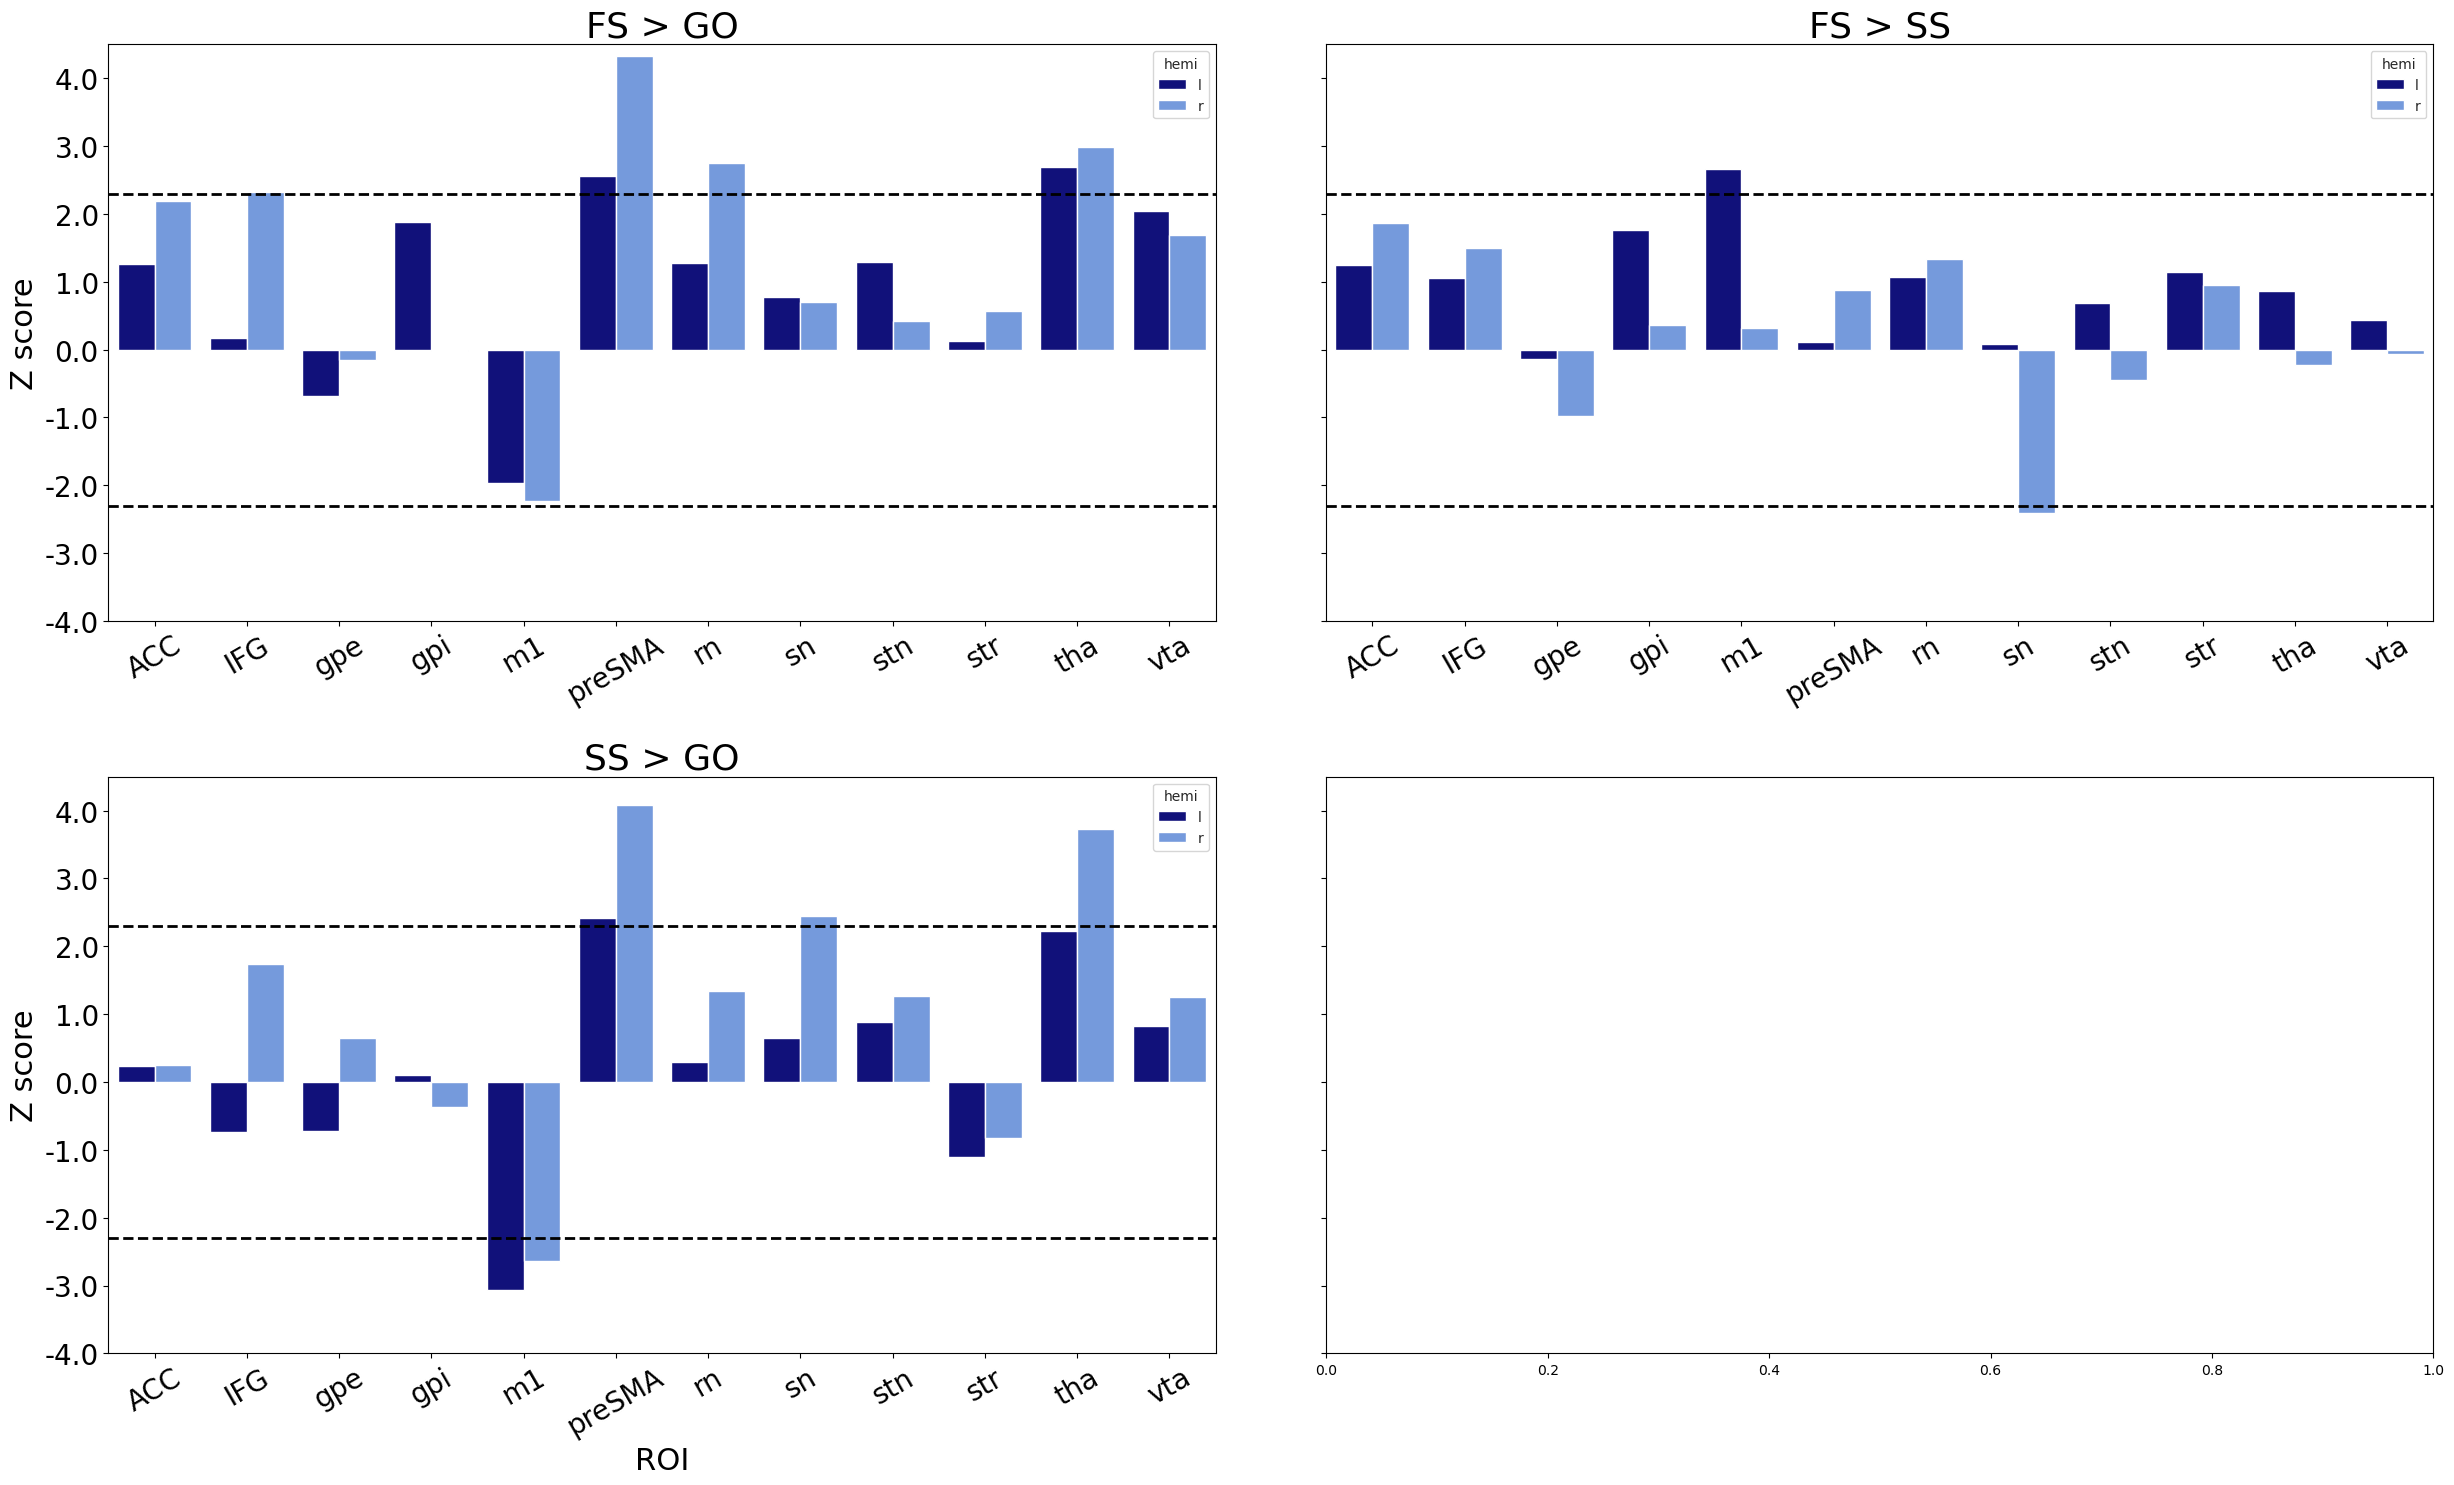

In [16]:
f, axes = plt.subplots(2,2, figsize=(30,17), sharex=False,sharey=True)
ax = axes.ravel()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.27)
# sns.set_style('darkgrid')

fs_go_stats = zstat_results[zstat_results['contrast']=='fs-go']
ss_go_stats = zstat_results[zstat_results['contrast']=='ss-go']
fs_ss_stats = zstat_results[zstat_results['contrast']=='fs-ss']

ylim_low, ylim_high = -4, 4.5

with sns.axes_style("whitegrid"):

    ## 2
    sns.barplot(x='roi', y='zstat', hue='hemi', 
                data=fs_go_stats, ax=ax[0],palette=("darkblue","cornflowerblue"))
    ax[0].set_ylabel('Z score', fontsize=22)
    ax[0].set_xlabel('')
#     ax[0].legend_.remove()
    ax[0].set_title('FS > GO', fontsize=26)
    ax[0].set(ylim=(ylim_low,ylim_high))
#     add_asteriks(1, contrast_betas_fsgo, 'beta_fs-go', stat_fsgo['significance'])
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)
    # ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)
    ax[0].set_yticklabels(ax[1].get_yticks().round(2),fontsize=20)
    ax[0].axhline(2.3, ls='--', linewidth=2, color='black')
    ax[0].axhline(-2.3, ls='--', linewidth=2, color='black')

    ## 3
    sns.barplot(x='roi', y='zstat', hue='hemi', 
                data=fs_ss_stats, ax=ax[1],palette=("darkblue","cornflowerblue"))
    ax[1].set_ylabel('', fontsize=22)
    ax[1].set_xlabel('', fontsize=22)
#     ax[1].legend_.remove()
    ax[1].set_title('FS > SS', fontsize=26)
    ax[1].set(ylim=(ylim_low,ylim_high))
#     add_asteriks(2, contrast_betas_fsss, 'beta_fs-ss', stat_fsss['significance'])
    ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)
#     ax[1].set_yticklabels(ax[1].get_yticks().round(2),fontsize=20)
    ax[1].axhline(2.3, ls='--', linewidth=2, color='black')
    ax[1].axhline(-2.3, ls='--', linewidth=2, color='black')

    ## 4
    sns.barplot(x='roi', y='zstat', hue='hemi', 
                data=ss_go_stats, ax=ax[2],palette=("darkblue","cornflowerblue"))
    ax[2].set_ylabel('Z score', fontsize=22)
    ax[2].set_xlabel('ROI', fontsize=22)
#     ax[2].legend_.remove()
    ax[2].set_title('SS > GO', fontsize=26)
    ax[2].set(ylim=(ylim_low,ylim_high))
#     add_asteriks(3, contrast_betas_ssgo, 'beta_ss-go', stat_ssgo['significance'])
    ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation = 30,fontsize=20)
    ax[2].set_yticklabels(ax[3].get_yticks().round(2),fontsize=20)
    ax[2].axhline(2.3, ls='--', linewidth=2, color='black')
    ax[2].axhline(-2.3, ls='--', linewidth=2, color='black')

#     for x in range(4) :[t.set_color(i) for (i,t) in zip(['orange']*7+['red']*8,ax[x].get_xticklabels())]

#     f.savefig('figure_download_scott/GLM_ROI_SST_contrasts.pdf', bbox_inches='tight')

# SJSI NTNU

In [19]:
dataset = 'NTNU_7T_SJSI'
base_dir = f'../derivatives/glm_feat_sst_roi/group_level_model/{dataset}'
fwhm = '1p5'

## FS-Go

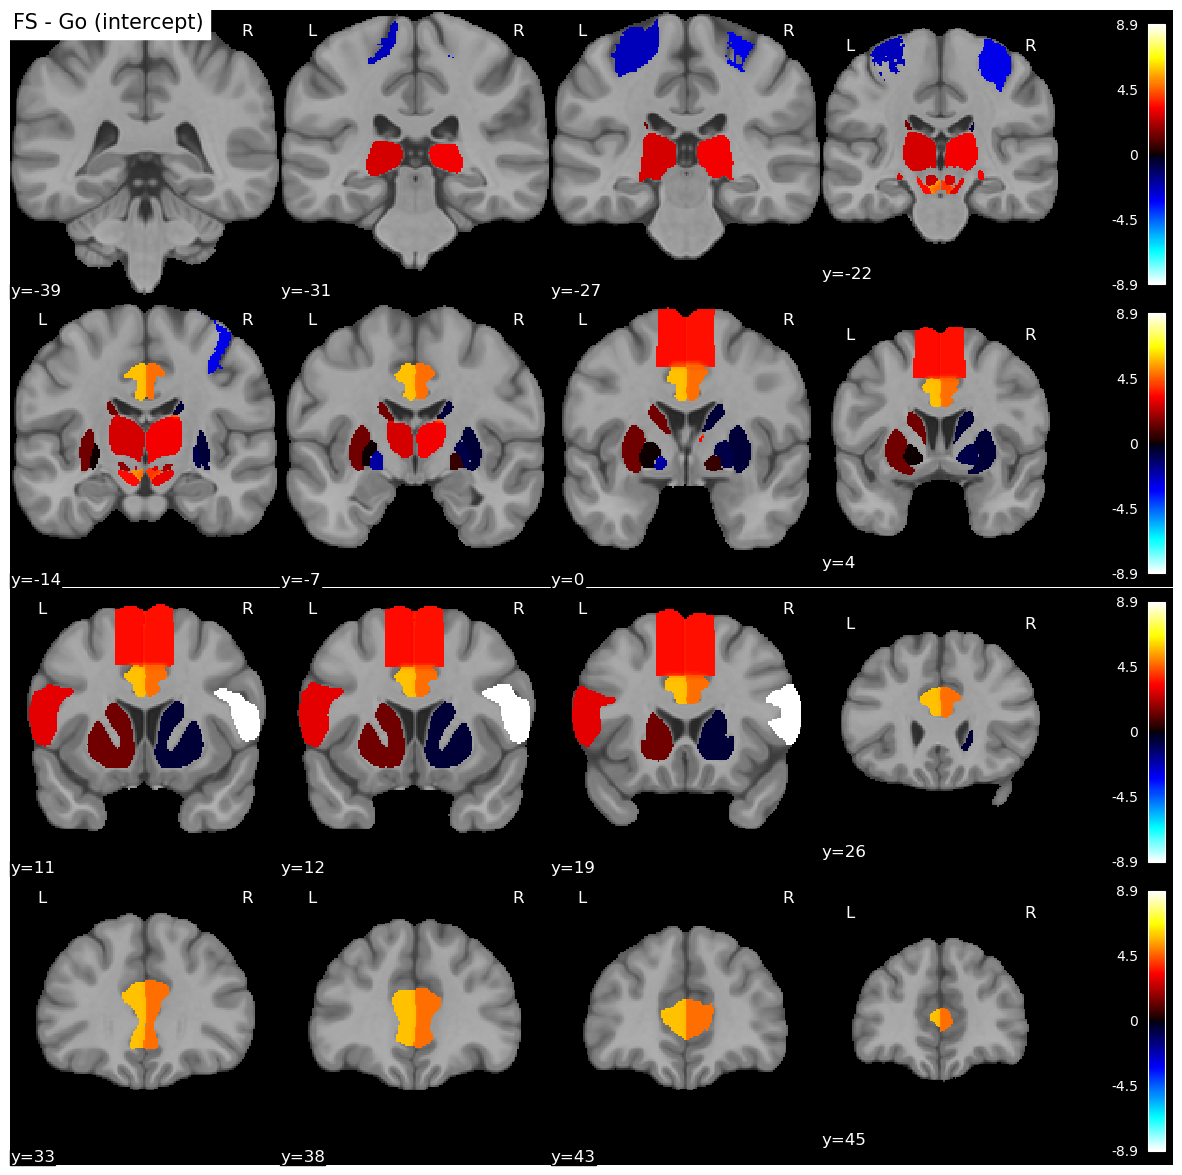

In [20]:
fs_go_intercept, threshold = get_second_level_zmap('fs-go', 'intercept', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False,  base_dir=base_dir, flame='12')
f, ax = plot_4x4(fs_go_intercept, display_mode='y', threshold=0, bg_img=mni09c, title='FS - Go (intercept)')

# extract z stat from ROI

In [21]:
def get_mni_roi_masks():
    
    masks = sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/sourcedata/useful_masks_mni09c1mm/*'))
    
    return masks


In [22]:
these_masks = get_mni_roi_masks()
contrasts = ['fs-go','fs-ss','ss-go']

contrast = []
roi = []
zstat = []
hemi = []
for this_contrast in contrasts:
    intercept, threshold = get_second_level_zmap(this_contrast, 'intercept', fwhm=fwhm, thresholding=None,model_n=0,from_working_dir=False,  base_dir=base_dir, flame='12')
    intercept = intercept.get_fdata()
    print(this_contrast)
    for this_mask in these_masks:

        load_mask = nib.load(this_mask).get_fdata()
        this_roi = this_mask.split('_label-')[-1].split('.')[0].split('-')[0]
        this_hemi = this_mask.split('_label-')[-1].split('.')[0].split('-')[1]
#         print(this_roi)

        roi_z = intercept[:,:,:][load_mask>0.5]

        contrast.append(this_contrast)
        roi.append(this_roi)
        zstat.append(float(mode(roi_z)[0]))
#         zstat.append(roi_z.mean())
        hemi.append(this_hemi)
        
zstat_results = pd.DataFrame(list(zip(contrast,roi,hemi,zstat)),columns=['contrast','roi','hemi','zstat'])
zstat_results['pstat'] = scipy.stats.norm.sf(abs(zstat_results['zstat'])) #one-sided

fsgostats = zstat_results[zstat_results['contrast'] == 'fs-go']
fsssstats = zstat_results[zstat_results['contrast'] == 'fs-ss']
ssgostats = zstat_results[zstat_results['contrast'] == 'ss-go']

add_stats = pd.concat([pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(fsgostats['pstat'], method='i'), index=['fdr_significant', 'p_corrected'], columns=fsgostats.index).T,
pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(fsssstats['pstat'], method='i'), index=['fdr_significant', 'p_corrected'], columns=fsssstats.index).T,
pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(ssgostats['pstat'], method='i'), index=['fdr_significant', 'p_corrected'], columns=ssgostats.index).T], axis=0)

zstat_results = pd.concat([zstat_results,add_stats],axis=1)
zstat_results['significance'] = ''
zstat_results.loc[zstat_results['p_corrected']<=0.05,'significance']='*'
zstat_results.loc[zstat_results['p_corrected']<=0.01,'significance']='**'
zstat_results.loc[zstat_results['p_corrected']<=0.001,'significance']='***'

fs-go


/tmp/ipykernel_1256457/540254859.py:23: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  zstat.append(float(mode(roi_z)[0]))


fs-ss
ss-go


In [23]:
zstat_results

,contrast,roi,hemi,zstat,pstat,fdr_significant,p_corrected,significance
0,fs-go,ACC,l,5.792111,3.475361e-09,True,0.0,***
1,fs-go,ACC,r,4.687251,1.384499e-06,True,0.000011,***
2,fs-go,IFG,l,2.926232,1.715477e-03,True,0.003431,**
3,fs-go,IFG,r,8.929690,2.136014e-19,True,0.0,***
4,fs-go,gpe,l,0.062627,4.750316e-01,False,0.475032,
...,...,...,...,...,...,...,...,...
67,ss-go,str,r,-3.441026,2.897562e-04,True,0.001159,**
68,ss-go,tha,l,-4.271042,9.728073e-06,True,0.000078,***
69,ss-go,tha,r,-2.096653,1.801215e-02,True,0.030147,*
70,ss-go,vta,l,-0.168238,4.331979e-01,False,0.452033,


/tmp/ipykernel_1256457/2396881000.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ax[1].get_yticks().round(2),fontsize=20)
/tmp/ipykernel_1256457/2396881000.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_yticklabels(ax[3].get_yticks().round(2),fontsize=20)


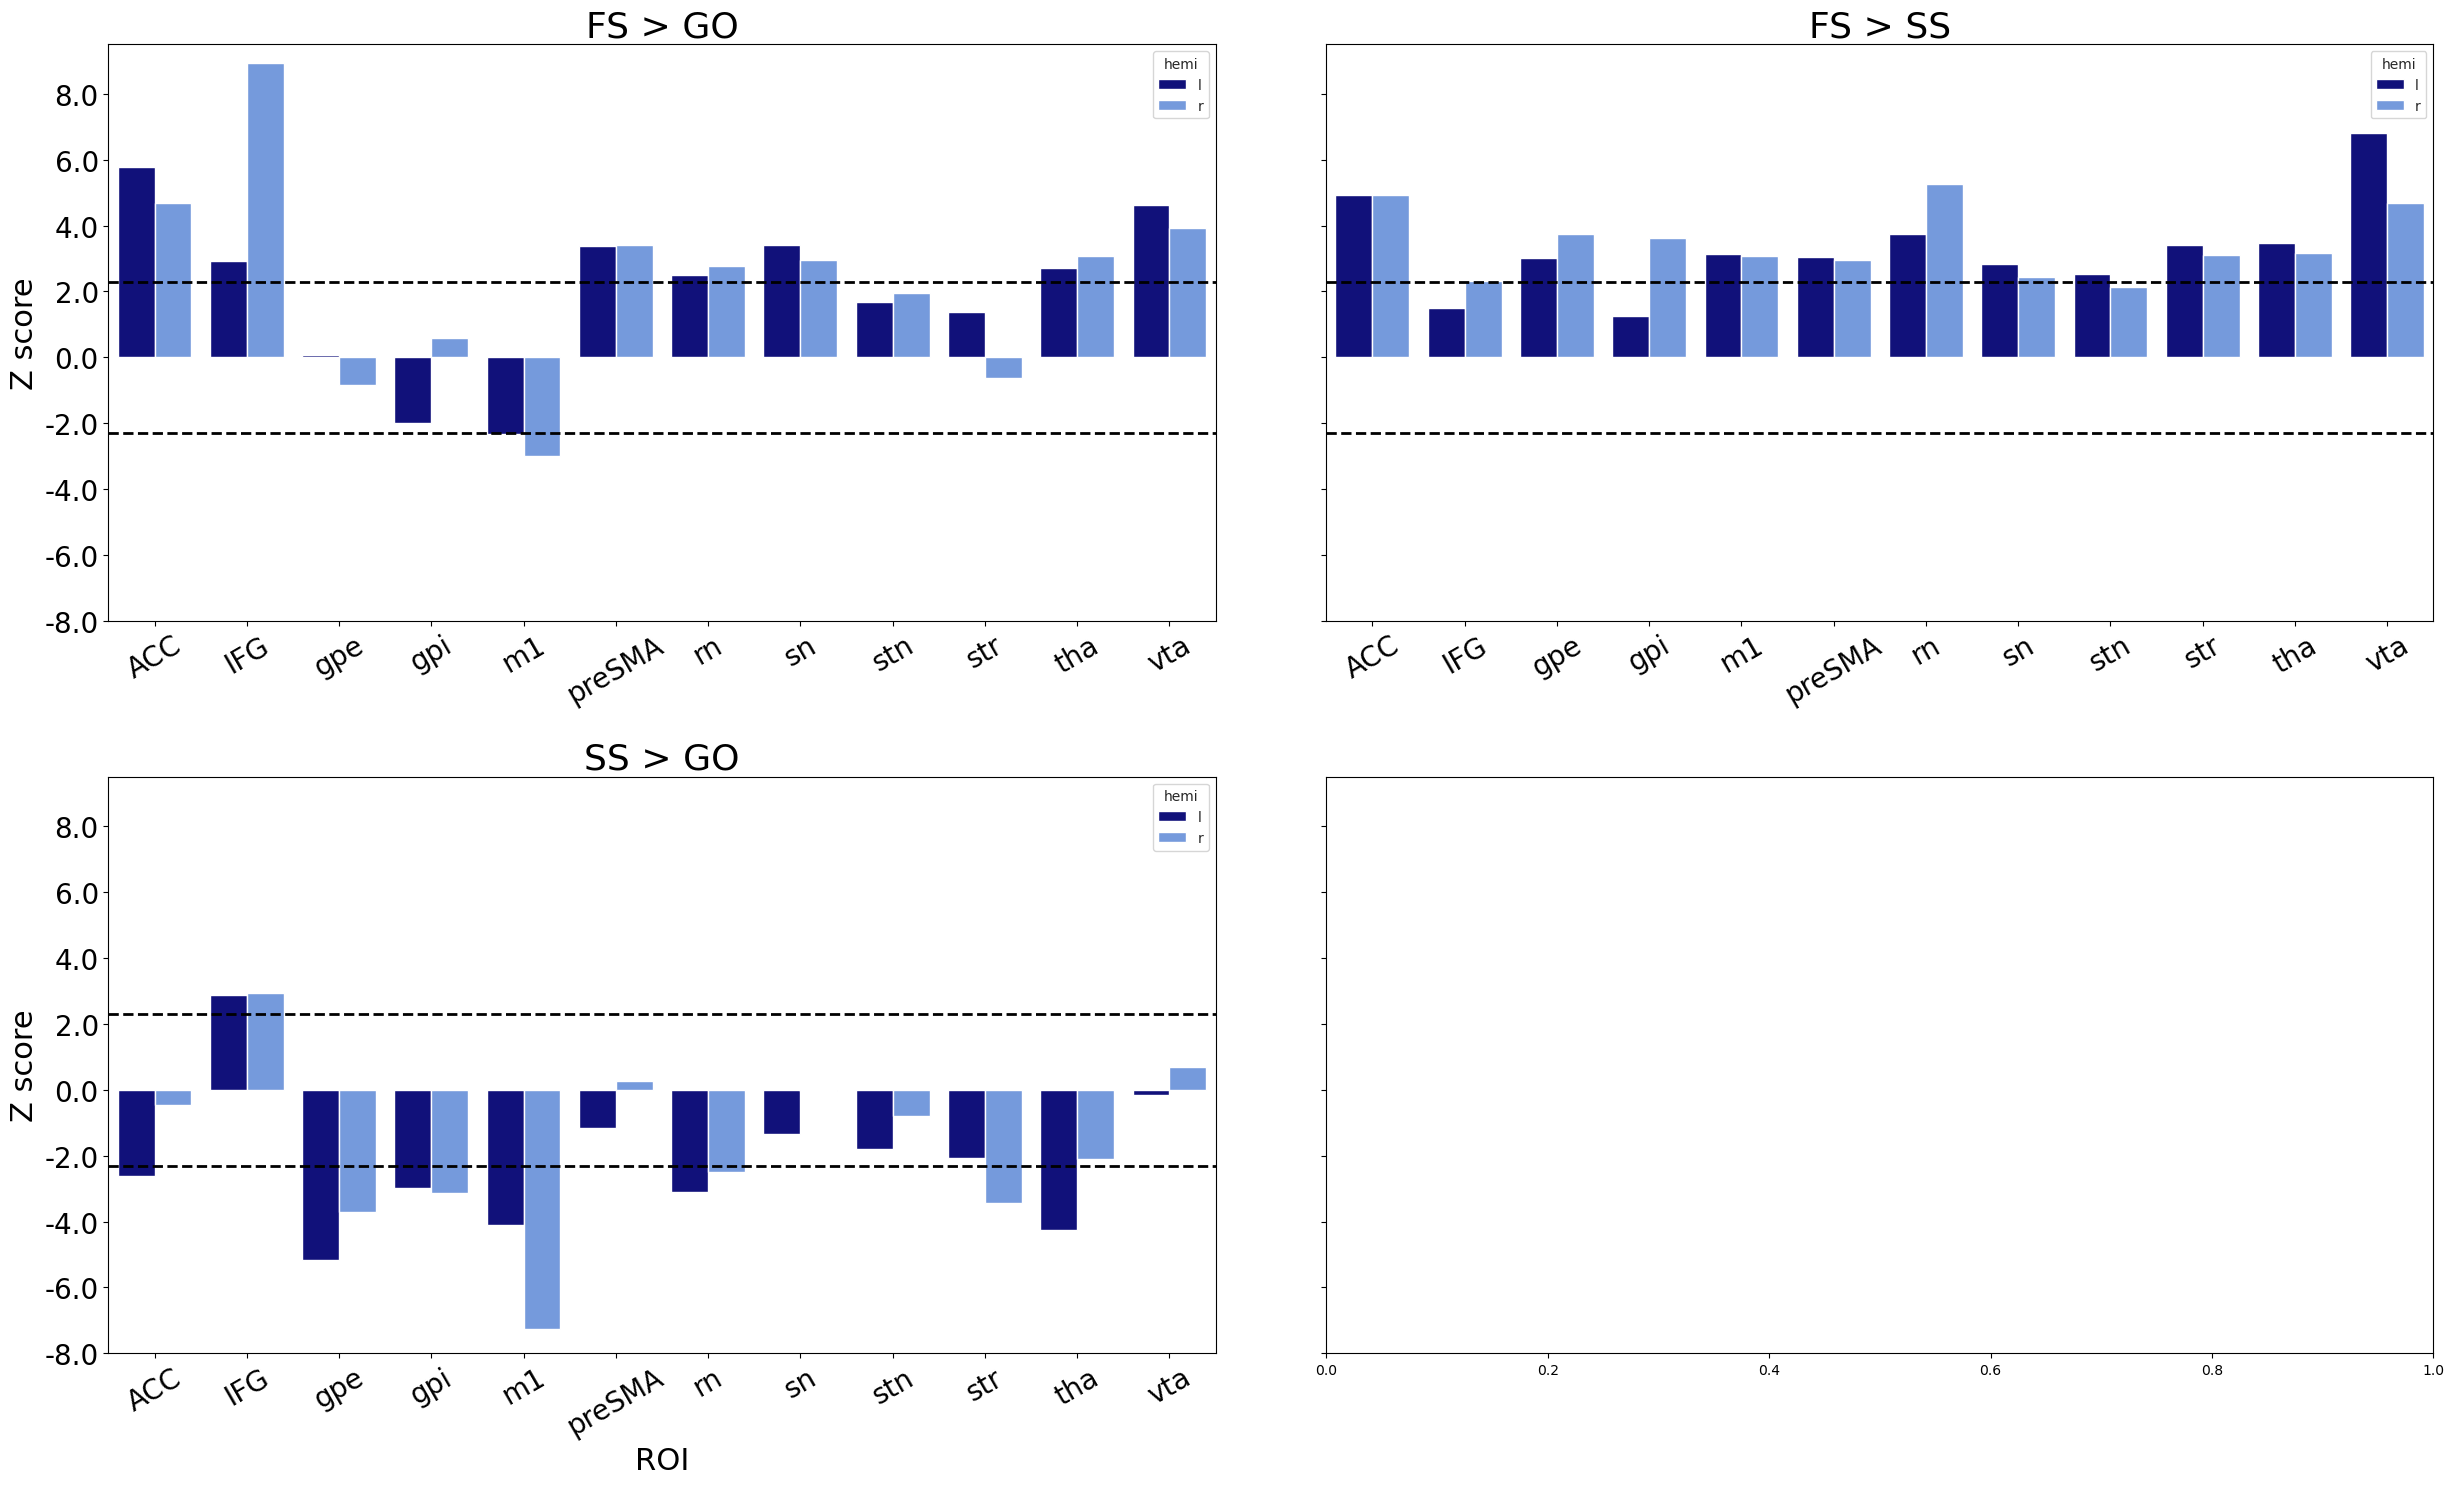

In [31]:
f, axes = plt.subplots(2,2, figsize=(30,17), sharex=False,sharey=True)
ax = axes.ravel()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.27)
# sns.set_style('darkgrid')

fs_go_stats = zstat_results[zstat_results['contrast']=='fs-go']
ss_go_stats = zstat_results[zstat_results['contrast']=='ss-go']
fs_ss_stats = zstat_results[zstat_results['contrast']=='fs-ss']

ylim_low, ylim_high = -8, 9.5

with sns.axes_style("whitegrid"):

    ## 2
    sns.barplot(x='roi', y='zstat', hue='hemi', 
                data=fs_go_stats, ax=ax[0],palette=("darkblue","cornflowerblue"))
    ax[0].set_ylabel('Z score', fontsize=22)
    ax[0].set_xlabel('')
#     ax[0].legend_.remove()
    ax[0].set_title('FS > GO', fontsize=26)
    ax[0].set(ylim=(ylim_low,ylim_high))
#     add_asteriks(1, contrast_betas_fsgo, 'beta_fs-go', stat_fsgo['significance'])
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)
    # ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)
    ax[0].set_yticklabels(ax[1].get_yticks().round(2),fontsize=20)
    ax[0].axhline(2.3, ls='--', linewidth=2, color='black')
    ax[0].axhline(-2.3, ls='--', linewidth=2, color='black')

    ## 3
    sns.barplot(x='roi', y='zstat', hue='hemi', 
                data=fs_ss_stats, ax=ax[1],palette=("darkblue","cornflowerblue"))
    ax[1].set_ylabel('', fontsize=22)
    ax[1].set_xlabel('', fontsize=22)
#     ax[1].legend_.remove()
    ax[1].set_title('FS > SS', fontsize=26)
    ax[1].set(ylim=(ylim_low,ylim_high))
#     add_asteriks(2, contrast_betas_fsss, 'beta_fs-ss', stat_fsss['significance'])
    ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)
#     ax[1].set_yticklabels(ax[1].get_yticks().round(2),fontsize=20)
    ax[1].axhline(2.3, ls='--', linewidth=2, color='black')
    ax[1].axhline(-2.3, ls='--', linewidth=2, color='black')

    ## 4
    sns.barplot(x='roi', y='zstat', hue='hemi', 
                data=ss_go_stats, ax=ax[2],palette=("darkblue","cornflowerblue"))
    ax[2].set_ylabel('Z score', fontsize=22)
    ax[2].set_xlabel('ROI', fontsize=22)
#     ax[2].legend_.remove()
    ax[2].set_title('SS > GO', fontsize=26)
    ax[2].set(ylim=(ylim_low,ylim_high))
#     add_asteriks(3, contrast_betas_ssgo, 'beta_ss-go', stat_ssgo['significance'])
    ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation = 30,fontsize=20)
    ax[2].set_yticklabels(ax[3].get_yticks().round(2),fontsize=20)
    ax[2].axhline(2.3, ls='--', linewidth=2, color='black')
    ax[2].axhline(-2.3, ls='--', linewidth=2, color='black')

#     for x in range(4) :[t.set_color(i) for (i,t) in zip(['orange']*7+['red']*8,ax[x].get_xticklabels())]

#     f.savefig('figure_download_scott/GLM_ROI_SST_contrasts.pdf', bbox_inches='tight')

# openfmri

In [32]:
dataset = 'openfmri_3T'
base_dir = f'../derivatives/glm_feat_sst_roi/group_level_model/{dataset}'
fwhm = '1p5'

## FS-Go

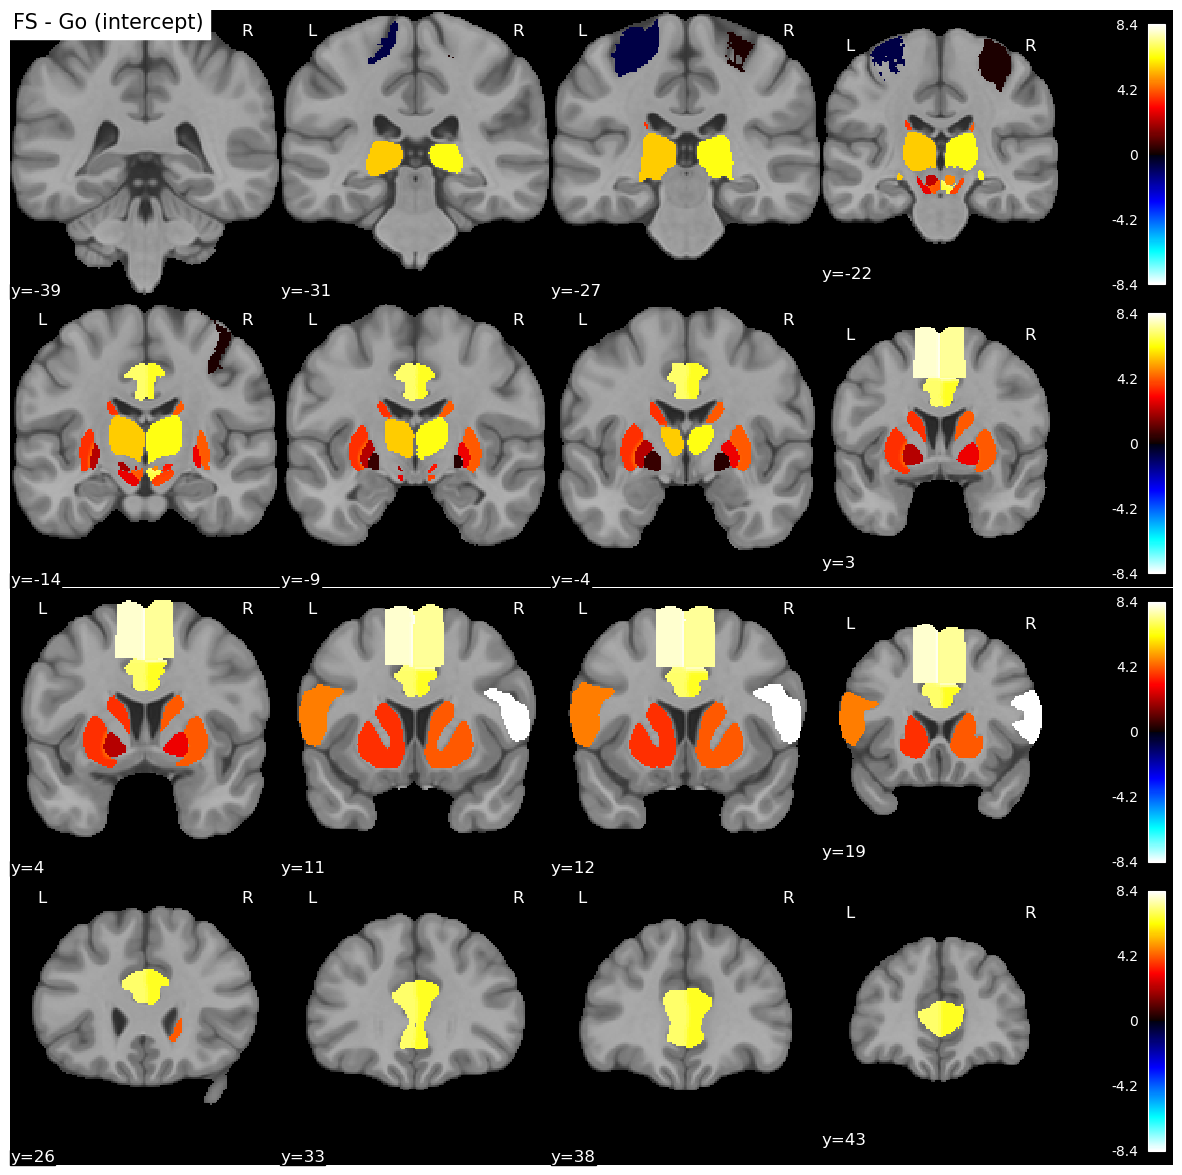

In [33]:
fs_go_intercept, threshold = get_second_level_zmap('fs-go', 'intercept', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False,  base_dir=base_dir, flame='12')
f, ax = plot_4x4(fs_go_intercept, display_mode='y', threshold=0, bg_img=mni09c, title='FS - Go (intercept)')

# extract z stat from ROI

In [34]:
def get_mni_roi_masks():
    
    masks = sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/sourcedata/useful_masks_mni09c1mm/*'))
    
    return masks


In [35]:
these_masks = get_mni_roi_masks()
contrasts = ['fs-go','fs-ss','ss-go']

contrast = []
roi = []
zstat = []
hemi = []
for this_contrast in contrasts:
    intercept, threshold = get_second_level_zmap(this_contrast, 'intercept', fwhm=fwhm, thresholding=None,model_n=0,from_working_dir=False,  base_dir=base_dir, flame='12')
    intercept = intercept.get_fdata()
    print(this_contrast)
    for this_mask in these_masks:

        load_mask = nib.load(this_mask).get_fdata()
        this_roi = this_mask.split('_label-')[-1].split('.')[0].split('-')[0]
        this_hemi = this_mask.split('_label-')[-1].split('.')[0].split('-')[1]
#         print(this_roi)

        roi_z = intercept[:,:,:][load_mask>0.5]

        contrast.append(this_contrast)
        roi.append(this_roi)
        zstat.append(float(mode(roi_z)[0]))
#         zstat.append(roi_z.mean())
        hemi.append(this_hemi)
        
zstat_results = pd.DataFrame(list(zip(contrast,roi,hemi,zstat)),columns=['contrast','roi','hemi','zstat'])
zstat_results['pstat'] = scipy.stats.norm.sf(abs(zstat_results['zstat'])) #one-sided

fsgostats = zstat_results[zstat_results['contrast'] == 'fs-go']
fsssstats = zstat_results[zstat_results['contrast'] == 'fs-ss']
ssgostats = zstat_results[zstat_results['contrast'] == 'ss-go']

add_stats = pd.concat([pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(fsgostats['pstat'], method='i'), index=['fdr_significant', 'p_corrected'], columns=fsgostats.index).T,
pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(fsssstats['pstat'], method='i'), index=['fdr_significant', 'p_corrected'], columns=fsssstats.index).T,
pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(ssgostats['pstat'], method='i'), index=['fdr_significant', 'p_corrected'], columns=ssgostats.index).T], axis=0)

zstat_results = pd.concat([zstat_results,add_stats],axis=1)
zstat_results['significance'] = ''
zstat_results.loc[zstat_results['p_corrected']<=0.05,'significance']='*'
zstat_results.loc[zstat_results['p_corrected']<=0.01,'significance']='**'
zstat_results.loc[zstat_results['p_corrected']<=0.001,'significance']='***'

fs-go


/tmp/ipykernel_1256457/540254859.py:23: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  zstat.append(float(mode(roi_z)[0]))


fs-ss
ss-go


In [36]:
zstat_results

,contrast,roi,hemi,zstat,pstat,fdr_significant,p_corrected,significance
0,fs-go,ACC,l,7.138863,4.705300e-13,True,0.0,***
1,fs-go,ACC,r,6.525569,3.387183e-11,True,0.0,***
2,fs-go,IFG,l,4.593925,2.174924e-06,True,0.000005,***
3,fs-go,IFG,r,8.394801,2.333417e-17,True,0.0,***
4,fs-go,gpe,l,2.163476,1.525231e-02,True,0.019266,*
...,...,...,...,...,...,...,...,...
67,ss-go,str,r,1.111173,1.332469e-01,False,0.152282,
68,ss-go,tha,l,3.622869,1.456766e-04,True,0.000437,***
69,ss-go,tha,r,4.406686,5.248213e-06,True,0.000031,***
70,ss-go,vta,l,2.491142,6.366656e-03,True,0.010519,*


/tmp/ipykernel_1256457/2713033975.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ax[1].get_yticks().round(2),fontsize=20)
/tmp/ipykernel_1256457/2713033975.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_yticklabels(ax[3].get_yticks().round(2),fontsize=20)


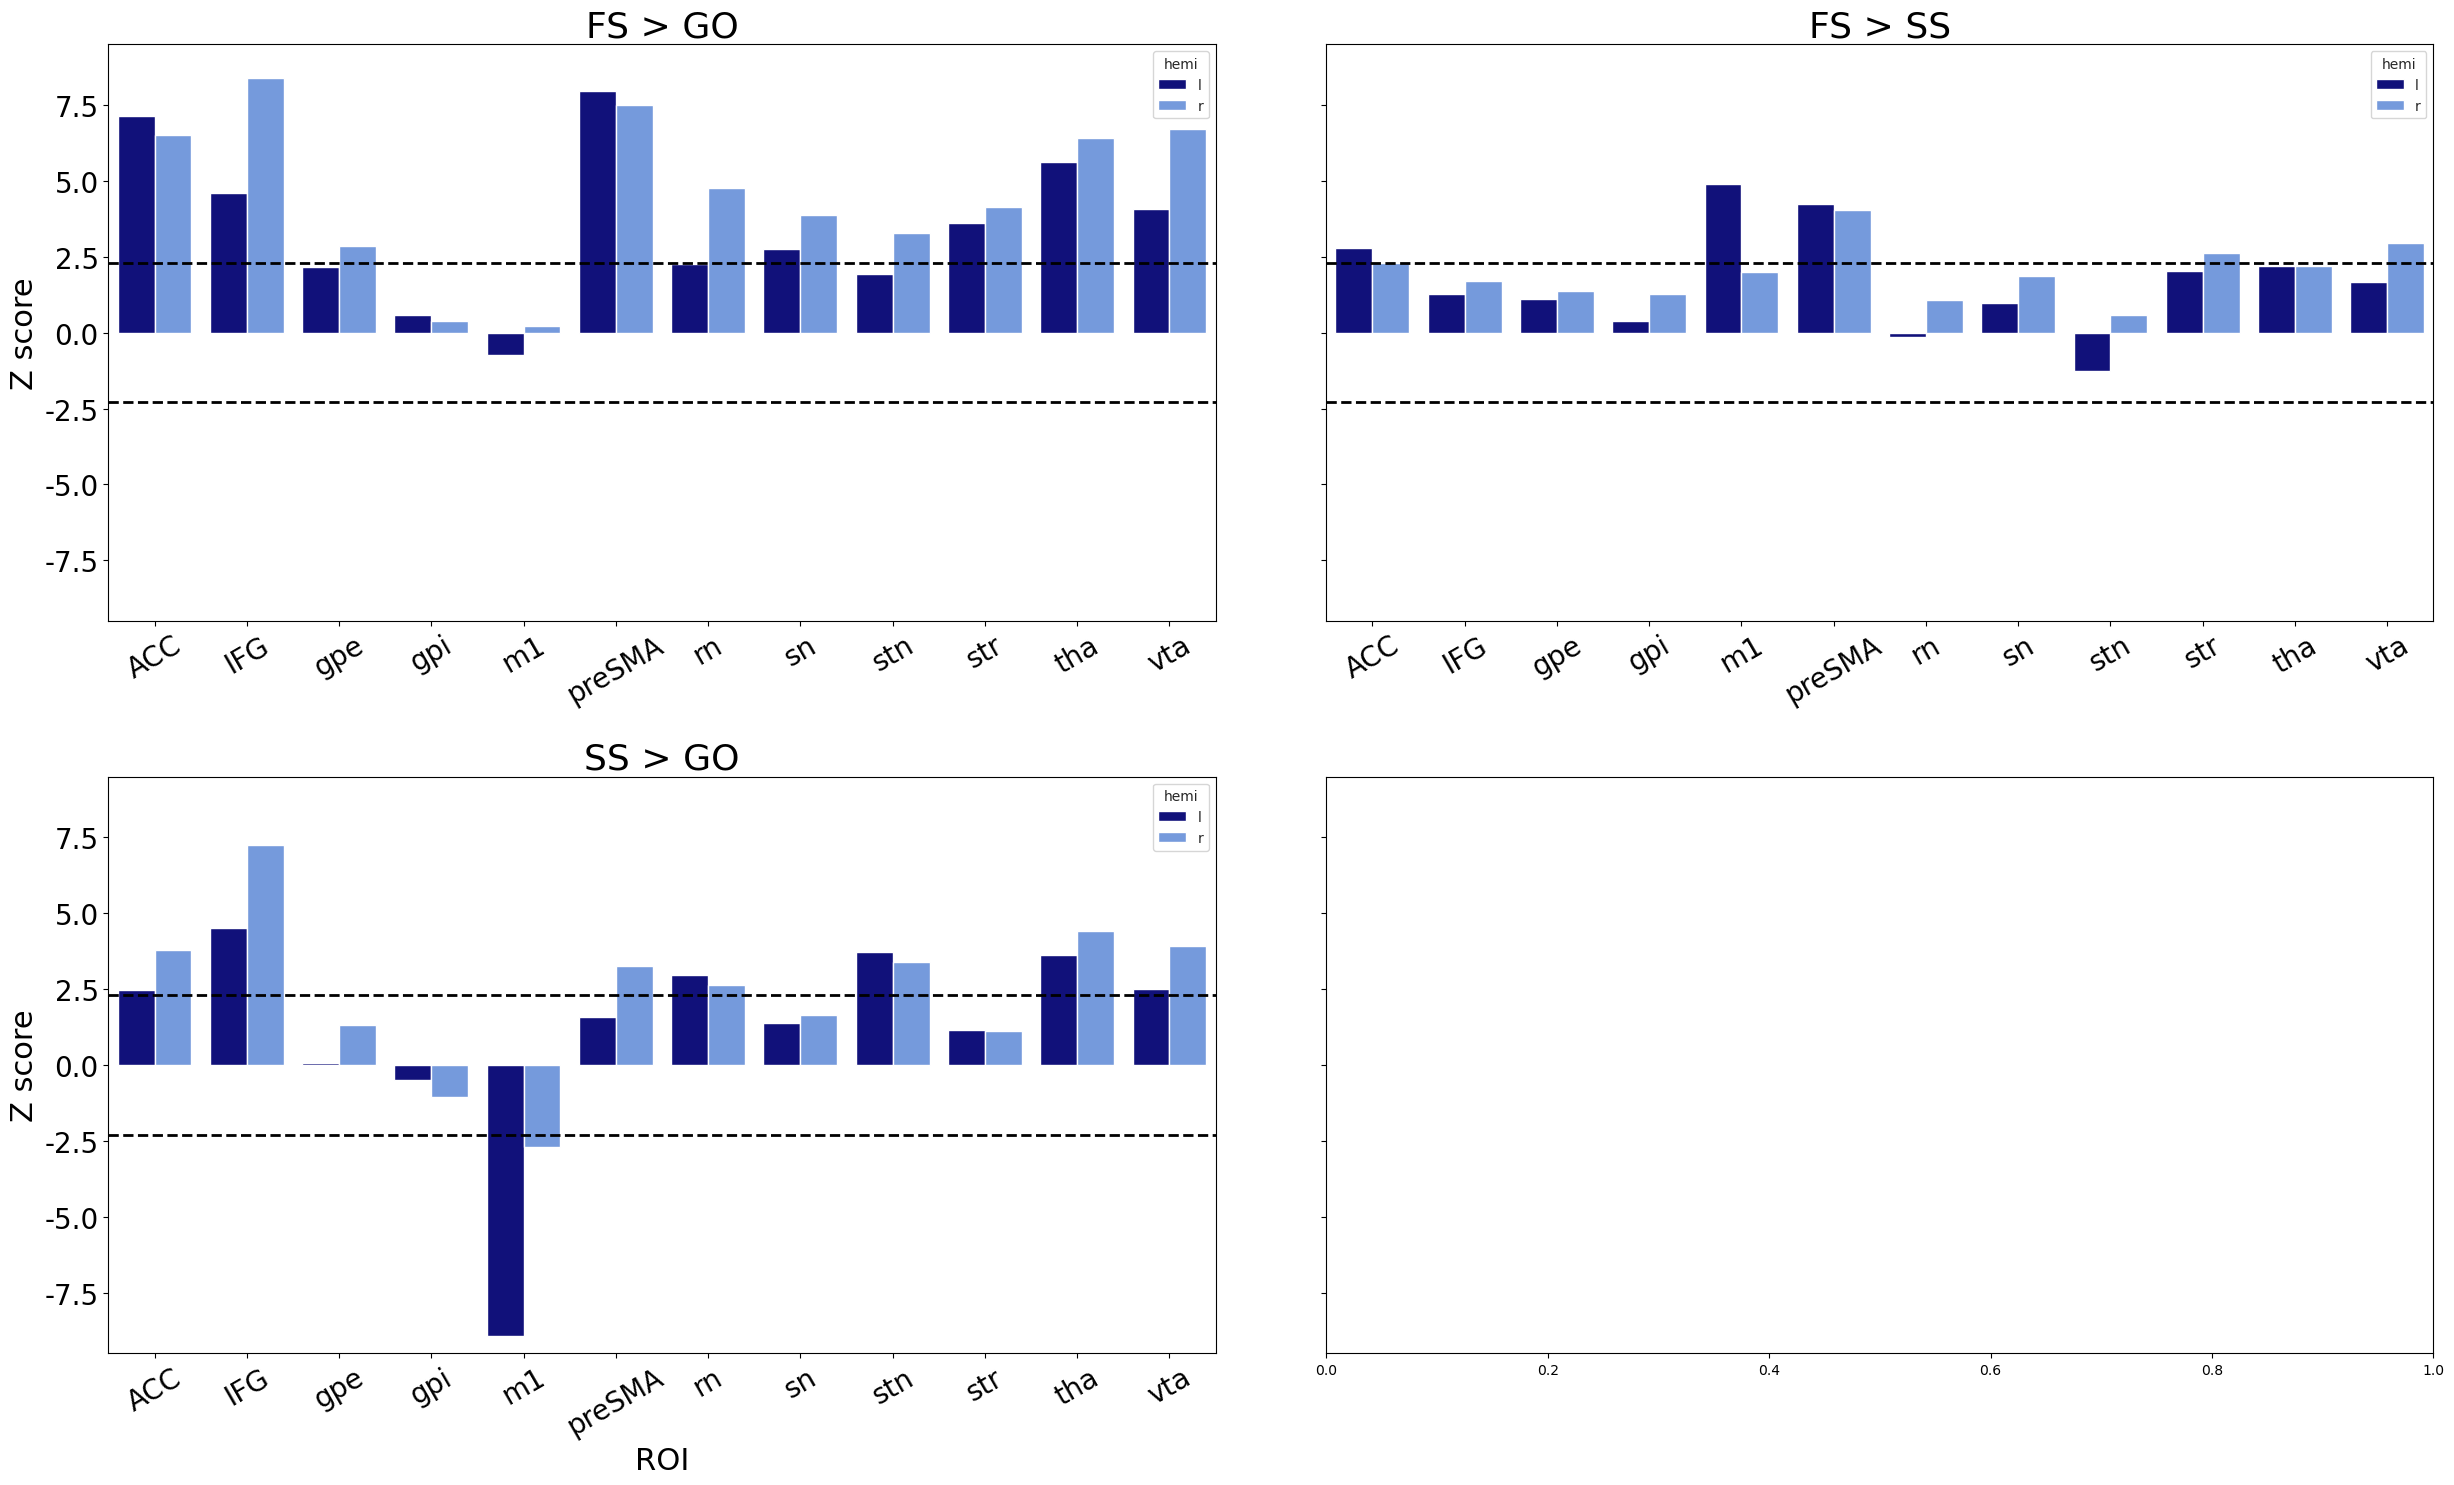

In [39]:
f, axes = plt.subplots(2,2, figsize=(30,17), sharex=False,sharey=True)
ax = axes.ravel()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.27)
# sns.set_style('darkgrid')

fs_go_stats = zstat_results[zstat_results['contrast']=='fs-go']
ss_go_stats = zstat_results[zstat_results['contrast']=='ss-go']
fs_ss_stats = zstat_results[zstat_results['contrast']=='fs-ss']

ylim_low, ylim_high = -9.5, 9.5

with sns.axes_style("whitegrid"):

    ## 2
    sns.barplot(x='roi', y='zstat', hue='hemi', 
                data=fs_go_stats, ax=ax[0],palette=("darkblue","cornflowerblue"))
    ax[0].set_ylabel('Z score', fontsize=22)
    ax[0].set_xlabel('')
#     ax[0].legend_.remove()
    ax[0].set_title('FS > GO', fontsize=26)
    ax[0].set(ylim=(ylim_low,ylim_high))
#     add_asteriks(1, contrast_betas_fsgo, 'beta_fs-go', stat_fsgo['significance'])
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)
    # ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)
    ax[0].set_yticklabels(ax[1].get_yticks().round(2),fontsize=20)
    ax[0].axhline(2.3, ls='--', linewidth=2, color='black')
    ax[0].axhline(-2.3, ls='--', linewidth=2, color='black')

    ## 3
    sns.barplot(x='roi', y='zstat', hue='hemi', 
                data=fs_ss_stats, ax=ax[1],palette=("darkblue","cornflowerblue"))
    ax[1].set_ylabel('', fontsize=22)
    ax[1].set_xlabel('', fontsize=22)
#     ax[1].legend_.remove()
    ax[1].set_title('FS > SS', fontsize=26)
    ax[1].set(ylim=(ylim_low,ylim_high))
#     add_asteriks(2, contrast_betas_fsss, 'beta_fs-ss', stat_fsss['significance'])
    ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)
#     ax[1].set_yticklabels(ax[1].get_yticks().round(2),fontsize=20)
    ax[1].axhline(2.3, ls='--', linewidth=2, color='black')
    ax[1].axhline(-2.3, ls='--', linewidth=2, color='black')

    ## 4
    sns.barplot(x='roi', y='zstat', hue='hemi', 
                data=ss_go_stats, ax=ax[2],palette=("darkblue","cornflowerblue"))
    ax[2].set_ylabel('Z score', fontsize=22)
    ax[2].set_xlabel('ROI', fontsize=22)
#     ax[2].legend_.remove()
    ax[2].set_title('SS > GO', fontsize=26)
    ax[2].set(ylim=(ylim_low,ylim_high))
#     add_asteriks(3, contrast_betas_ssgo, 'beta_ss-go', stat_ssgo['significance'])
    ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation = 30,fontsize=20)
    ax[2].set_yticklabels(ax[3].get_yticks().round(2),fontsize=20)
    ax[2].axhline(2.3, ls='--', linewidth=2, color='black')
    ax[2].axhline(-2.3, ls='--', linewidth=2, color='black')

#     for x in range(4) :[t.set_color(i) for (i,t) in zip(['orange']*7+['red']*8,ax[x].get_xticklabels())]

#     f.savefig('figure_download_scott/GLM_ROI_SST_contrasts.pdf', bbox_inches='tight')

# GdH

In [40]:
dataset = 'Leipzig_7T_GdH'
base_dir = f'../derivatives/glm_feat_sst_roi/group_level_model/{dataset}'
fwhm = '1p5'

## FS-Go

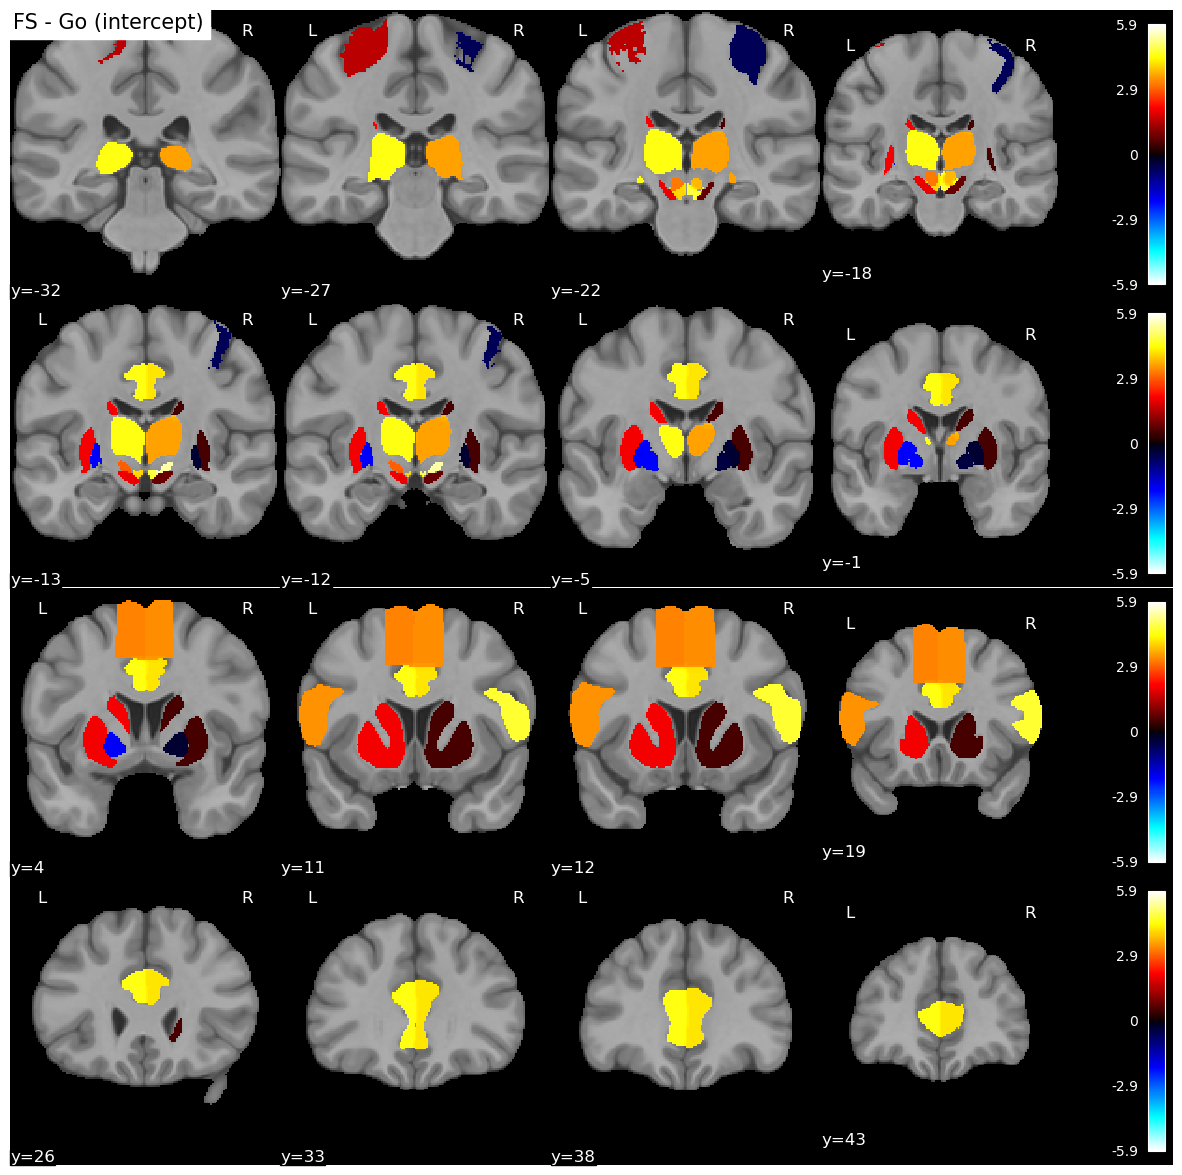

In [41]:
fs_go_intercept, threshold = get_second_level_zmap('fs-go', 'intercept', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False,  base_dir=base_dir, flame='12')
f, ax = plot_4x4(fs_go_intercept, display_mode='y', threshold=0, bg_img=mni09c, title='FS - Go (intercept)')

# extract z stat from ROI

In [42]:
def get_mni_roi_masks():
    
    masks = sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/sourcedata/useful_masks_mni09c1mm/*'))
    
    return masks


In [43]:
these_masks = get_mni_roi_masks()
contrasts = ['fs-go','fs-ss','ss-go']

contrast = []
roi = []
zstat = []
hemi = []
for this_contrast in contrasts:
    intercept, threshold = get_second_level_zmap(this_contrast, 'intercept', fwhm=fwhm, thresholding=None,model_n=0,from_working_dir=False,  base_dir=base_dir, flame='12')
    intercept = intercept.get_fdata()
    print(this_contrast)
    for this_mask in these_masks:

        load_mask = nib.load(this_mask).get_fdata()
        this_roi = this_mask.split('_label-')[-1].split('.')[0].split('-')[0]
        this_hemi = this_mask.split('_label-')[-1].split('.')[0].split('-')[1]
#         print(this_roi)

        roi_z = intercept[:,:,:][load_mask>0.5]

        contrast.append(this_contrast)
        roi.append(this_roi)
        zstat.append(float(mode(roi_z)[0]))
#         zstat.append(roi_z.mean())
        hemi.append(this_hemi)
        
zstat_results = pd.DataFrame(list(zip(contrast,roi,hemi,zstat)),columns=['contrast','roi','hemi','zstat'])
zstat_results['pstat'] = scipy.stats.norm.sf(abs(zstat_results['zstat'])) #one-sided

fsgostats = zstat_results[zstat_results['contrast'] == 'fs-go']
fsssstats = zstat_results[zstat_results['contrast'] == 'fs-ss']
ssgostats = zstat_results[zstat_results['contrast'] == 'ss-go']

add_stats = pd.concat([pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(fsgostats['pstat'], method='i'), index=['fdr_significant', 'p_corrected'], columns=fsgostats.index).T,
pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(fsssstats['pstat'], method='i'), index=['fdr_significant', 'p_corrected'], columns=fsssstats.index).T,
pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(ssgostats['pstat'], method='i'), index=['fdr_significant', 'p_corrected'], columns=ssgostats.index).T], axis=0)

zstat_results = pd.concat([zstat_results,add_stats],axis=1)
zstat_results['significance'] = ''
zstat_results.loc[zstat_results['p_corrected']<=0.05,'significance']='*'
zstat_results.loc[zstat_results['p_corrected']<=0.01,'significance']='**'
zstat_results.loc[zstat_results['p_corrected']<=0.001,'significance']='***'

fs-go


/tmp/ipykernel_1256457/540254859.py:23: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  zstat.append(float(mode(roi_z)[0]))


fs-ss
ss-go


In [44]:
zstat_results

,contrast,roi,hemi,zstat,pstat,fdr_significant,p_corrected,significance
0,fs-go,ACC,l,4.457390,4.148182e-06,True,0.000021,***
1,fs-go,ACC,r,4.161579,1.580272e-05,True,0.000063,***
2,fs-go,IFG,l,3.390852,3.483786e-04,True,0.000782,***
3,fs-go,IFG,r,4.657891,1.597324e-06,True,0.000013,***
4,fs-go,gpe,l,-2.101748,1.778769e-02,True,0.026682,*
...,...,...,...,...,...,...,...,...
67,ss-go,str,r,-0.956307,1.694586e-01,False,0.214053,
68,ss-go,tha,l,3.887868,5.056431e-05,True,0.000303,***
69,ss-go,tha,r,2.833311,2.303430e-03,True,0.007897,**
70,ss-go,vta,l,2.998290,1.357496e-03,True,0.00543,**


/tmp/ipykernel_1256457/2396881000.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ax[1].get_yticks().round(2),fontsize=20)
/tmp/ipykernel_1256457/2396881000.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_yticklabels(ax[3].get_yticks().round(2),fontsize=20)


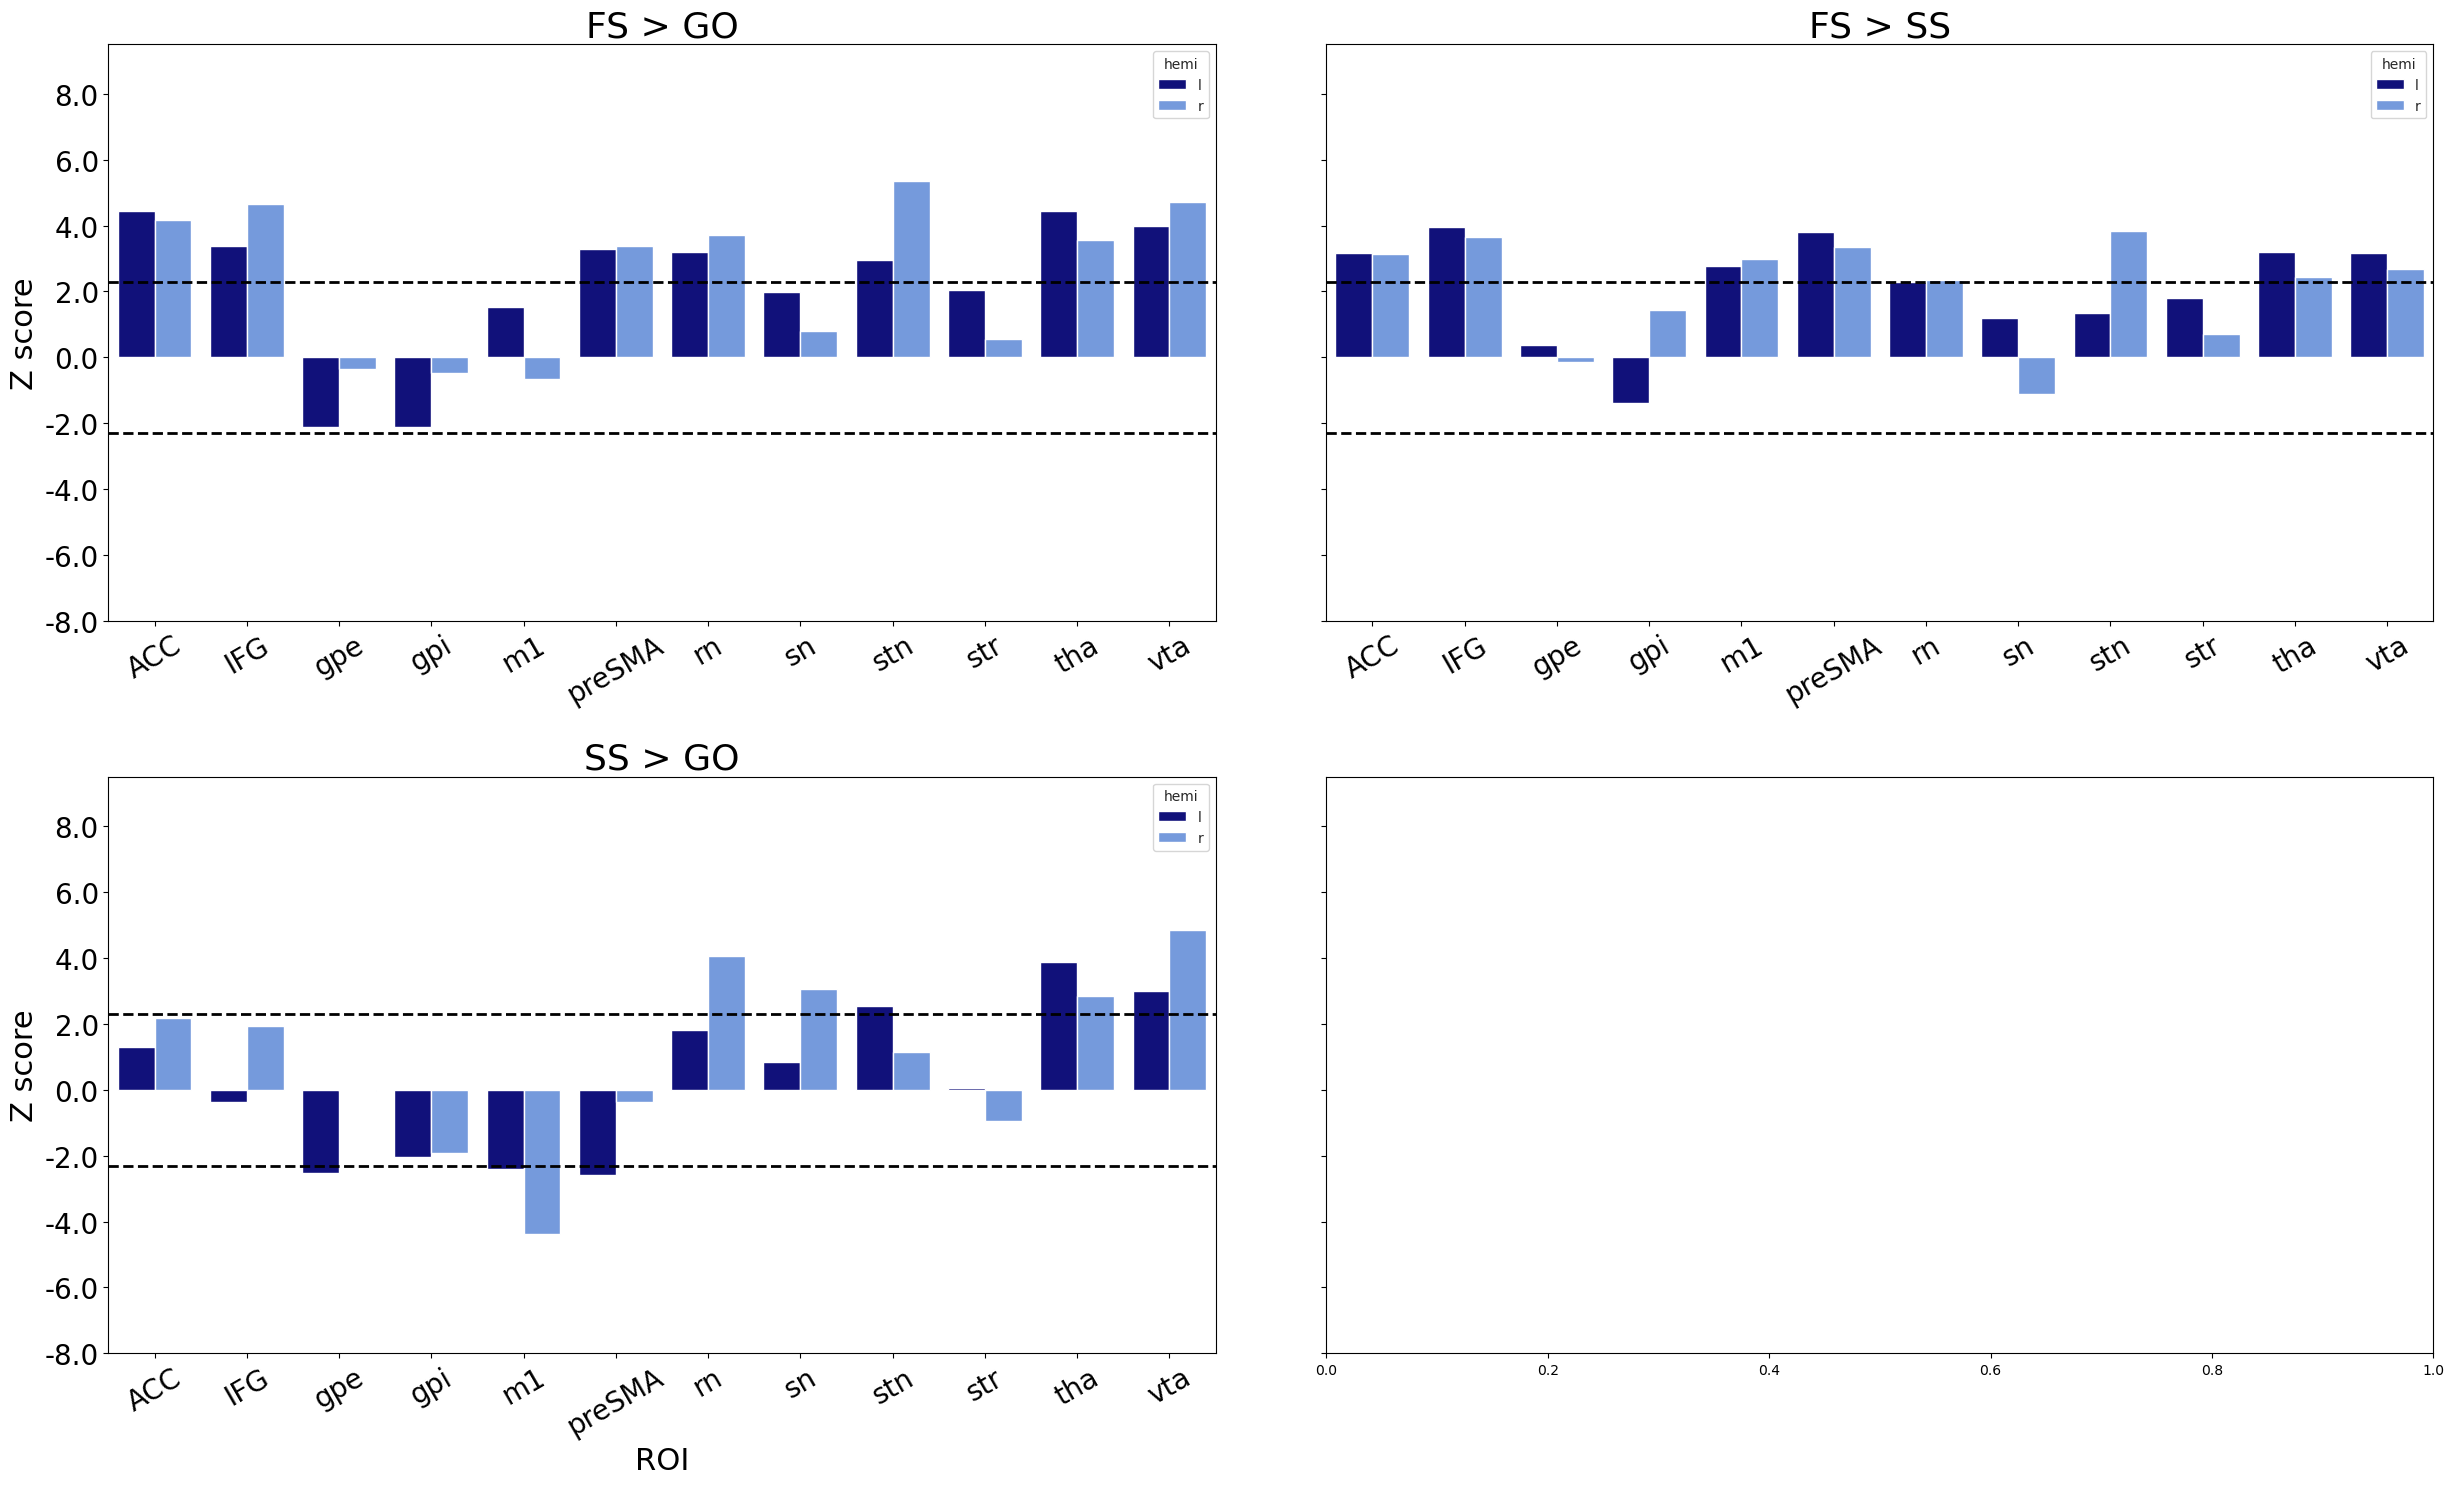

In [45]:
f, axes = plt.subplots(2,2, figsize=(30,17), sharex=False,sharey=True)
ax = axes.ravel()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.27)
# sns.set_style('darkgrid')

fs_go_stats = zstat_results[zstat_results['contrast']=='fs-go']
ss_go_stats = zstat_results[zstat_results['contrast']=='ss-go']
fs_ss_stats = zstat_results[zstat_results['contrast']=='fs-ss']

ylim_low, ylim_high = -8, 9.5

with sns.axes_style("whitegrid"):

    ## 2
    sns.barplot(x='roi', y='zstat', hue='hemi', 
                data=fs_go_stats, ax=ax[0],palette=("darkblue","cornflowerblue"))
    ax[0].set_ylabel('Z score', fontsize=22)
    ax[0].set_xlabel('')
#     ax[0].legend_.remove()
    ax[0].set_title('FS > GO', fontsize=26)
    ax[0].set(ylim=(ylim_low,ylim_high))
#     add_asteriks(1, contrast_betas_fsgo, 'beta_fs-go', stat_fsgo['significance'])
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)
    # ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)
    ax[0].set_yticklabels(ax[1].get_yticks().round(2),fontsize=20)
    ax[0].axhline(2.3, ls='--', linewidth=2, color='black')
    ax[0].axhline(-2.3, ls='--', linewidth=2, color='black')

    ## 3
    sns.barplot(x='roi', y='zstat', hue='hemi', 
                data=fs_ss_stats, ax=ax[1],palette=("darkblue","cornflowerblue"))
    ax[1].set_ylabel('', fontsize=22)
    ax[1].set_xlabel('', fontsize=22)
#     ax[1].legend_.remove()
    ax[1].set_title('FS > SS', fontsize=26)
    ax[1].set(ylim=(ylim_low,ylim_high))
#     add_asteriks(2, contrast_betas_fsss, 'beta_fs-ss', stat_fsss['significance'])
    ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)
#     ax[1].set_yticklabels(ax[1].get_yticks().round(2),fontsize=20)
    ax[1].axhline(2.3, ls='--', linewidth=2, color='black')
    ax[1].axhline(-2.3, ls='--', linewidth=2, color='black')

    ## 4
    sns.barplot(x='roi', y='zstat', hue='hemi', 
                data=ss_go_stats, ax=ax[2],palette=("darkblue","cornflowerblue"))
    ax[2].set_ylabel('Z score', fontsize=22)
    ax[2].set_xlabel('ROI', fontsize=22)
#     ax[2].legend_.remove()
    ax[2].set_title('SS > GO', fontsize=26)
    ax[2].set(ylim=(ylim_low,ylim_high))
#     add_asteriks(3, contrast_betas_ssgo, 'beta_ss-go', stat_ssgo['significance'])
    ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation = 30,fontsize=20)
    ax[2].set_yticklabels(ax[3].get_yticks().round(2),fontsize=20)
    ax[2].axhline(2.3, ls='--', linewidth=2, color='black')
    ax[2].axhline(-2.3, ls='--', linewidth=2, color='black')

#     for x in range(4) :[t.set_color(i) for (i,t) in zip(['orange']*7+['red']*8,ax[x].get_xticklabels())]

#     f.savefig('figure_download_scott/GLM_ROI_SST_contrasts.pdf', bbox_inches='tight')

# SM

In [46]:
dataset = 'Leipzig_7T_SM'
base_dir = f'../derivatives/glm_feat_sst_roi/group_level_model/{dataset}'
fwhm = '1p5'

## FS-Go

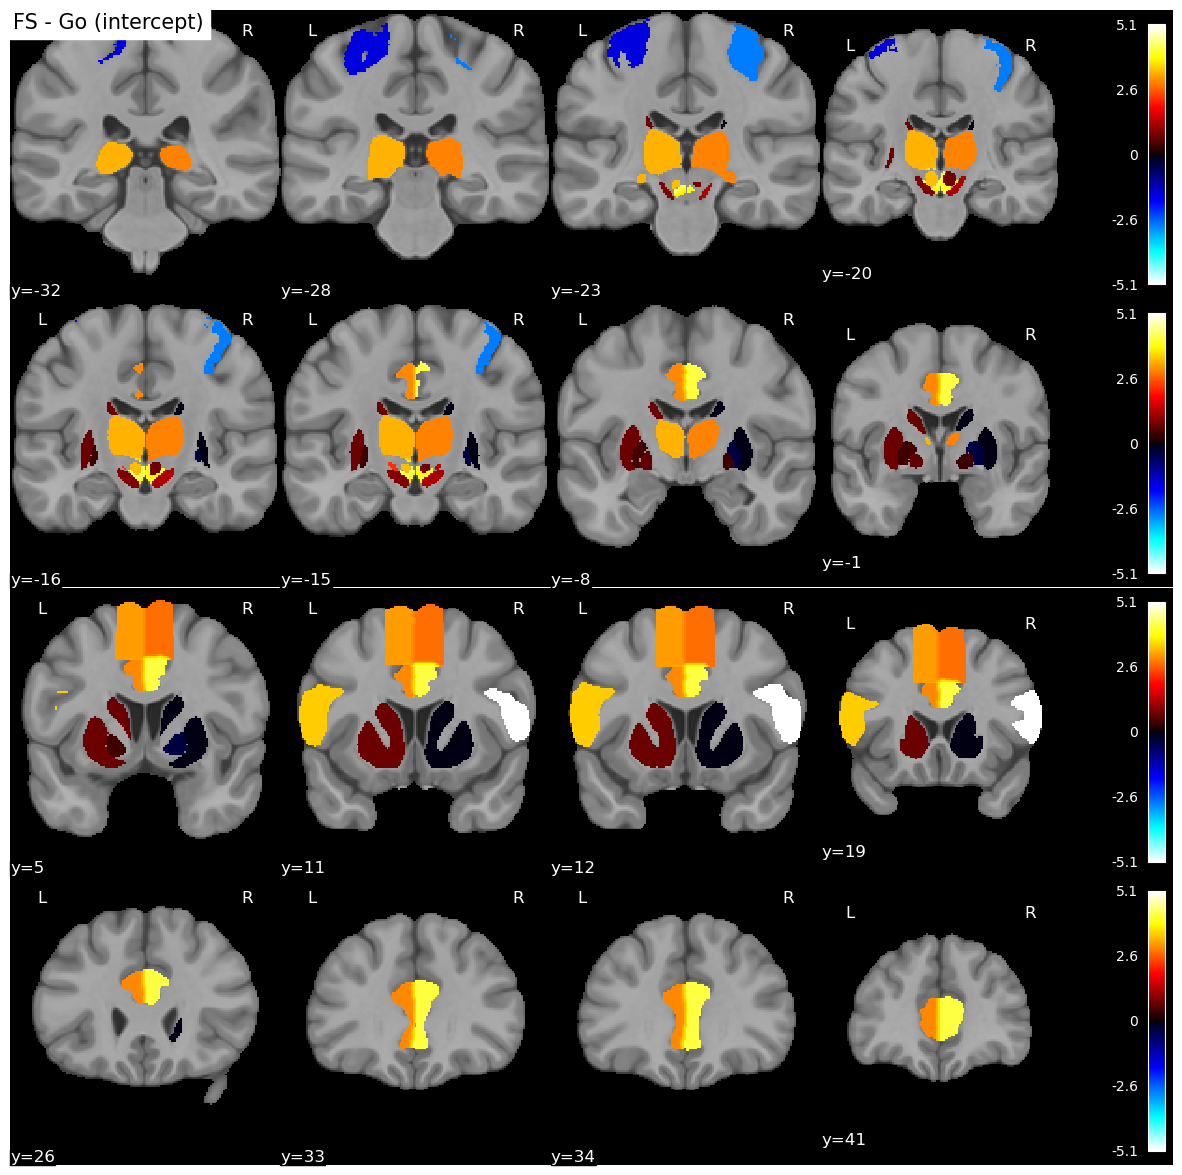

In [47]:
fs_go_intercept, threshold = get_second_level_zmap('fs-go', 'intercept', fwhm=fwhm, thresholding='fdr',model_n=0,from_working_dir=False,  base_dir=base_dir, flame='12')
f, ax = plot_4x4(fs_go_intercept, display_mode='y', threshold=0, bg_img=mni09c, title='FS - Go (intercept)')

# extract z stat from ROI

In [48]:
def get_mni_roi_masks():
    
    masks = sorted(glob.glob(f'/home/scotti/projects/3t_7t_sst_comparison/sourcedata/useful_masks_mni09c1mm/*'))
    
    return masks


In [49]:
these_masks = get_mni_roi_masks()
contrasts = ['fs-go','fs-ss','ss-go']

contrast = []
roi = []
zstat = []
hemi = []
for this_contrast in contrasts:
    intercept, threshold = get_second_level_zmap(this_contrast, 'intercept', fwhm=fwhm, thresholding=None,model_n=0,from_working_dir=False,  base_dir=base_dir, flame='12')
    intercept = intercept.get_fdata()
    print(this_contrast)
    for this_mask in these_masks:

        load_mask = nib.load(this_mask).get_fdata()
        this_roi = this_mask.split('_label-')[-1].split('.')[0].split('-')[0]
        this_hemi = this_mask.split('_label-')[-1].split('.')[0].split('-')[1]
#         print(this_roi)

        roi_z = intercept[:,:,:][load_mask>0.5]

        contrast.append(this_contrast)
        roi.append(this_roi)
        zstat.append(float(mode(roi_z)[0]))
#         zstat.append(roi_z.mean())
        hemi.append(this_hemi)
        
zstat_results = pd.DataFrame(list(zip(contrast,roi,hemi,zstat)),columns=['contrast','roi','hemi','zstat'])
zstat_results['pstat'] = scipy.stats.norm.sf(abs(zstat_results['zstat'])) #one-sided

fsgostats = zstat_results[zstat_results['contrast'] == 'fs-go']
fsssstats = zstat_results[zstat_results['contrast'] == 'fs-ss']
ssgostats = zstat_results[zstat_results['contrast'] == 'ss-go']

add_stats = pd.concat([pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(fsgostats['pstat'], method='i'), index=['fdr_significant', 'p_corrected'], columns=fsgostats.index).T,
pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(fsssstats['pstat'], method='i'), index=['fdr_significant', 'p_corrected'], columns=fsssstats.index).T,
pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(ssgostats['pstat'], method='i'), index=['fdr_significant', 'p_corrected'], columns=ssgostats.index).T], axis=0)

zstat_results = pd.concat([zstat_results,add_stats],axis=1)
zstat_results['significance'] = ''
zstat_results.loc[zstat_results['p_corrected']<=0.05,'significance']='*'
zstat_results.loc[zstat_results['p_corrected']<=0.01,'significance']='**'
zstat_results.loc[zstat_results['p_corrected']<=0.001,'significance']='***'

fs-go


/tmp/ipykernel_1256457/540254859.py:23: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  zstat.append(float(mode(roi_z)[0]))


fs-ss
ss-go


In [50]:
zstat_results

,contrast,roi,hemi,zstat,pstat,fdr_significant,p_corrected,significance
0,fs-go,ACC,l,2.886968,1.944871e-03,True,0.005186,**
1,fs-go,ACC,r,4.121202,1.884504e-05,True,0.000226,***
2,fs-go,IFG,l,3.415008,3.189003e-04,True,0.001531,**
3,fs-go,IFG,r,5.101361,1.686100e-07,True,0.000004,***
4,fs-go,gpe,l,0.408559,3.414317e-01,False,0.360589,
...,...,...,...,...,...,...,...,...
67,ss-go,str,r,-0.828108,2.038047e-01,False,0.257438,
68,ss-go,tha,l,1.630766,5.146984e-02,False,0.137253,
69,ss-go,tha,r,1.027160,1.521727e-01,False,0.214832,
70,ss-go,vta,l,1.074724,1.412492e-01,False,0.211874,


/tmp/ipykernel_1256457/2396881000.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ax[1].get_yticks().round(2),fontsize=20)
/tmp/ipykernel_1256457/2396881000.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_yticklabels(ax[3].get_yticks().round(2),fontsize=20)


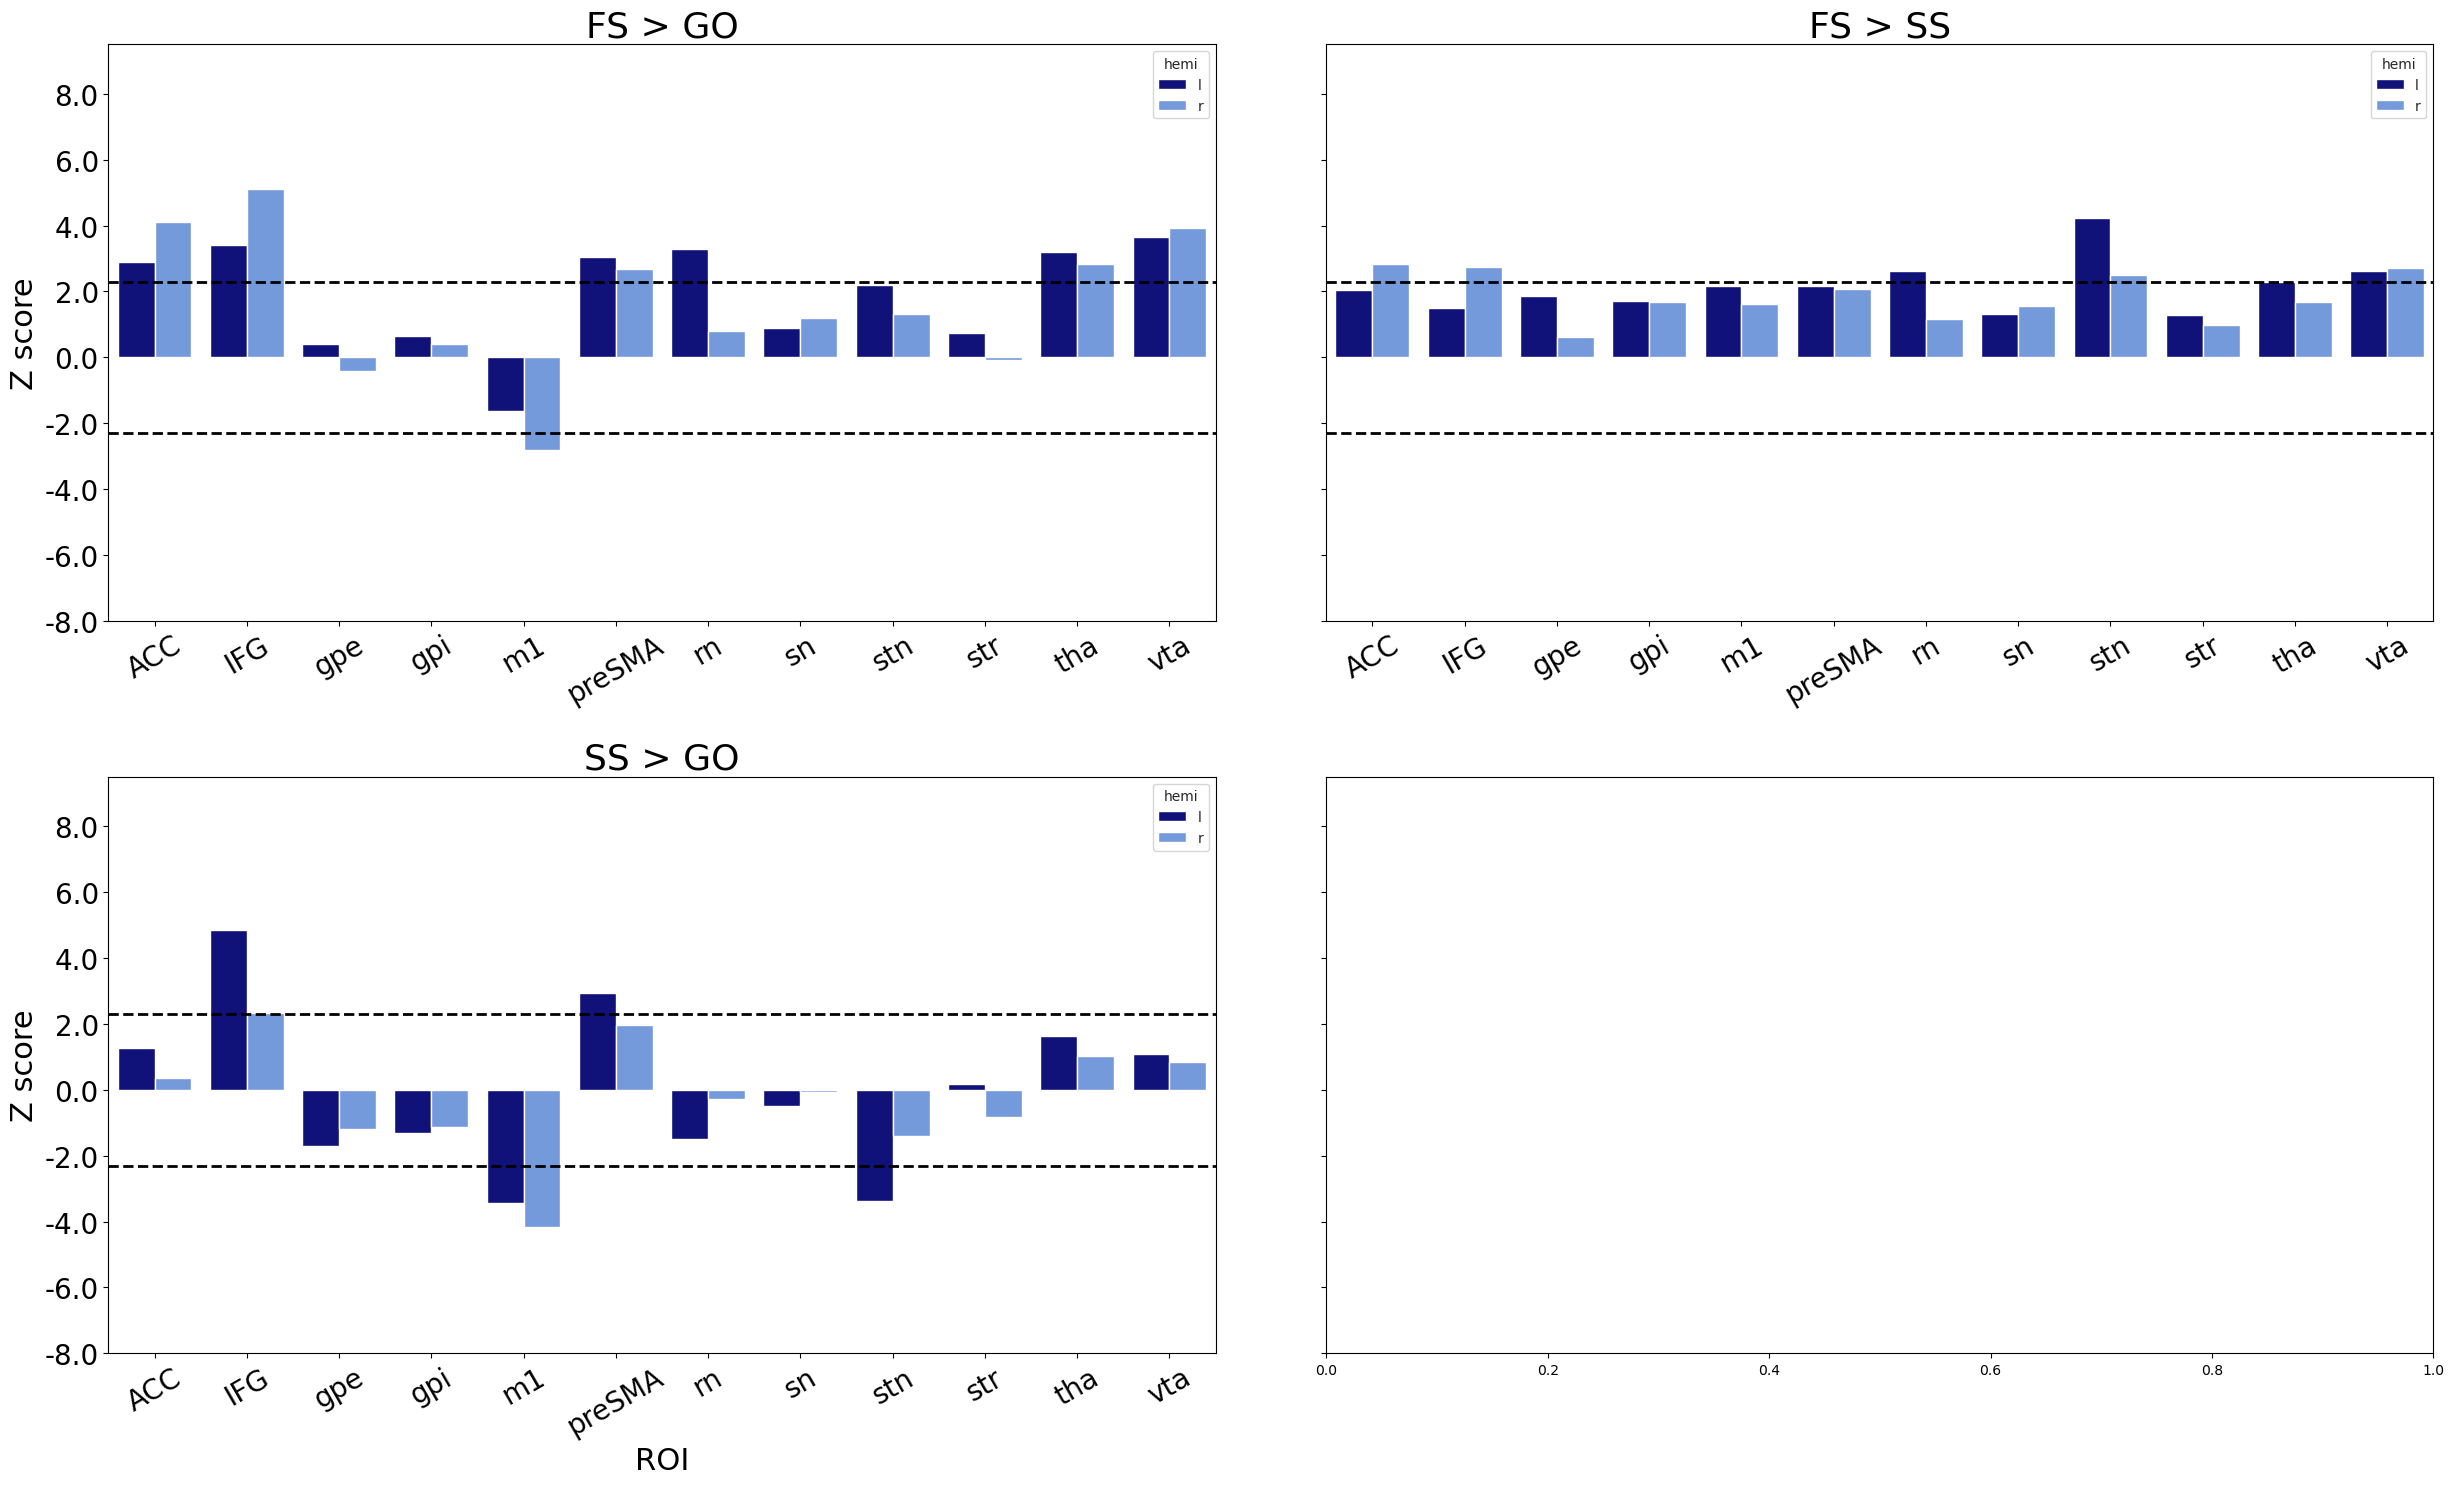

In [51]:
f, axes = plt.subplots(2,2, figsize=(30,17), sharex=False,sharey=True)
ax = axes.ravel()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.27)
# sns.set_style('darkgrid')

fs_go_stats = zstat_results[zstat_results['contrast']=='fs-go']
ss_go_stats = zstat_results[zstat_results['contrast']=='ss-go']
fs_ss_stats = zstat_results[zstat_results['contrast']=='fs-ss']

ylim_low, ylim_high = -8, 9.5

with sns.axes_style("whitegrid"):

    ## 2
    sns.barplot(x='roi', y='zstat', hue='hemi', 
                data=fs_go_stats, ax=ax[0],palette=("darkblue","cornflowerblue"))
    ax[0].set_ylabel('Z score', fontsize=22)
    ax[0].set_xlabel('')
#     ax[0].legend_.remove()
    ax[0].set_title('FS > GO', fontsize=26)
    ax[0].set(ylim=(ylim_low,ylim_high))
#     add_asteriks(1, contrast_betas_fsgo, 'beta_fs-go', stat_fsgo['significance'])
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)
    # ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)
    ax[0].set_yticklabels(ax[1].get_yticks().round(2),fontsize=20)
    ax[0].axhline(2.3, ls='--', linewidth=2, color='black')
    ax[0].axhline(-2.3, ls='--', linewidth=2, color='black')

    ## 3
    sns.barplot(x='roi', y='zstat', hue='hemi', 
                data=fs_ss_stats, ax=ax[1],palette=("darkblue","cornflowerblue"))
    ax[1].set_ylabel('', fontsize=22)
    ax[1].set_xlabel('', fontsize=22)
#     ax[1].legend_.remove()
    ax[1].set_title('FS > SS', fontsize=26)
    ax[1].set(ylim=(ylim_low,ylim_high))
#     add_asteriks(2, contrast_betas_fsss, 'beta_fs-ss', stat_fsss['significance'])
    ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)
#     ax[1].set_yticklabels(ax[1].get_yticks().round(2),fontsize=20)
    ax[1].axhline(2.3, ls='--', linewidth=2, color='black')
    ax[1].axhline(-2.3, ls='--', linewidth=2, color='black')

    ## 4
    sns.barplot(x='roi', y='zstat', hue='hemi', 
                data=ss_go_stats, ax=ax[2],palette=("darkblue","cornflowerblue"))
    ax[2].set_ylabel('Z score', fontsize=22)
    ax[2].set_xlabel('ROI', fontsize=22)
#     ax[2].legend_.remove()
    ax[2].set_title('SS > GO', fontsize=26)
    ax[2].set(ylim=(ylim_low,ylim_high))
#     add_asteriks(3, contrast_betas_ssgo, 'beta_ss-go', stat_ssgo['significance'])
    ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation = 30,fontsize=20)
    ax[2].set_yticklabels(ax[3].get_yticks().round(2),fontsize=20)
    ax[2].axhline(2.3, ls='--', linewidth=2, color='black')
    ax[2].axhline(-2.3, ls='--', linewidth=2, color='black')

#     for x in range(4) :[t.set_color(i) for (i,t) in zip(['orange']*7+['red']*8,ax[x].get_xticklabels())]

#     f.savefig('figure_download_scott/GLM_ROI_SST_contrasts.pdf', bbox_inches='tight')

In [6]:
stat_img = nib.load('../derivatives/fsl_feat_roi_func/aron_3T/sub-15/func/sub-15_task-stopsignal_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz').get_fdata()

In [9]:
these_masks = get_mni_roi_masks()

for this_mask in these_masks[:2]:
        
    load_mask = nib.load(this_mask).get_fdata()
    this_roi = this_mask.split('_label-')[-1].split('.')[0] 
    print(this_roi)
    
    roi_z = stat_img[:,:,:,1][load_mask>0.5]
    

ACC-l
ACC-r


In [11]:
roi_z

array([770.02500179, 770.02500179, 770.02500179, ..., 770.02500179,
       770.02500179, 770.02500179])

In [20]:
load_mask[load_mask>0.5]

array([0.5258044 , 0.56815594, 0.63769162, 0.54570931, 0.72102219,
       0.81395763, 0.84326714, 0.79059482, 0.67538095, 0.51367825,
       0.73101765, 0.86079293, 0.93423504, 0.92981619, 0.87835401,
       0.74663037, 0.56874758, 0.53830343, 0.58119768, 0.71987778,
       0.84681463, 0.91879565, 0.94895267, 0.92201728, 0.80278796,
       0.61716712, 0.53321338, 0.55210227, 0.76542187, 0.65587449,
       0.83997005, 0.92323864, 0.94052845, 0.91193497, 0.74885309,
       0.53043789, 0.51926416, 0.71068954, 0.76040304, 0.52318811,
       0.87495965, 0.94778204, 0.95152754, 0.84158766, 0.68523973,
       0.6572479 , 0.68147427, 0.8018865 , 0.78130519, 0.54263061,
       0.87660187, 0.94672322, 0.95245856, 0.94313133, 0.91738147,
       0.89697403, 0.88553554, 0.69350398, 0.59705687, 0.85951805,
       0.91203302, 0.91903961, 0.94182986, 0.93040502, 0.79922044,
       0.79269487, 0.81772792, 0.830064  , 0.75379467, 0.50979078,
       0.58106834, 0.53439575, 0.56461483, 0.68109125, 0.67318

In [11]:
cope = '/home/scotti/projects/3t_7t_sst_comparison/derivatives/glm_feat_sst_roi/group_level_model/aron_3T/model-0/model-0/model-0_subjectlevelcontrast-3_grouplevelcontrast-1_flame-12_desc-cope.nii.gz'
varcope = '/home/scotti/projects/3t_7t_sst_comparison/derivatives/glm_feat_sst_roi/group_level_model/aron_3T/model-0/model-0/model-0_subjectlevelcontrast-3_grouplevelcontrast-1_flame-12_desc-varcope.nii.gz'
zmap = '/home/scotti/projects/3t_7t_sst_comparison/derivatives/glm_feat_sst_roi/group_level_model/aron_3T/model-0/model-0/model-0_subjectlevelcontrast-3_grouplevelcontrast-1_flame-12_desc-zstat.nii.gz'

/home/scotti/.local/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


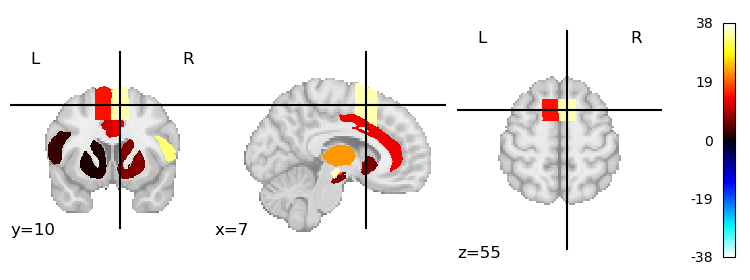

In [12]:
plotting.plot_stat_map(cope)

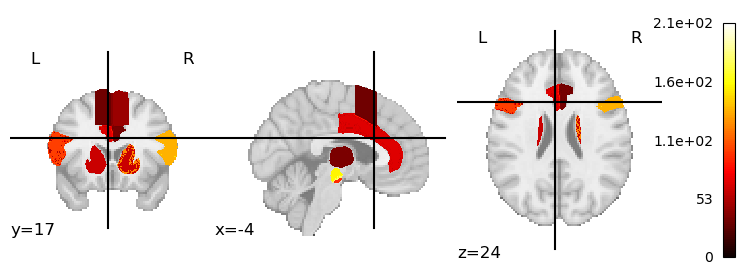

In [13]:
plotting.plot_stat_map(varcope)

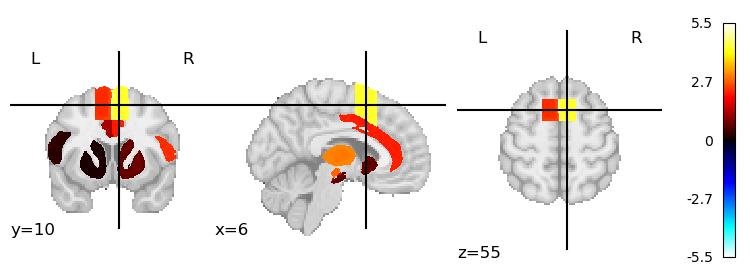

In [14]:
plotting.plot_stat_map(zmap)

In [15]:
cope = '/home/scotti/projects/3t_7t_sst_comparison/derivatives/glm_feat_sst_roi/group_level_model/aron_3T/model-0/model-0/model-0_subjectlevelcontrast-5_grouplevelcontrast-1_flame-12_desc-cope.nii.gz'
varcope = '/home/scotti/projects/3t_7t_sst_comparison/derivatives/glm_feat_sst_roi/group_level_model/aron_3T/model-0/model-0/model-0_subjectlevelcontrast-5_grouplevelcontrast-1_flame-12_desc-varcope.nii.gz'
zmap = '/home/scotti/projects/3t_7t_sst_comparison/derivatives/glm_feat_sst_roi/group_level_model/aron_3T/model-0/model-0/model-0_subjectlevelcontrast-5_grouplevelcontrast-1_flame-12_desc-zstat.nii.gz'

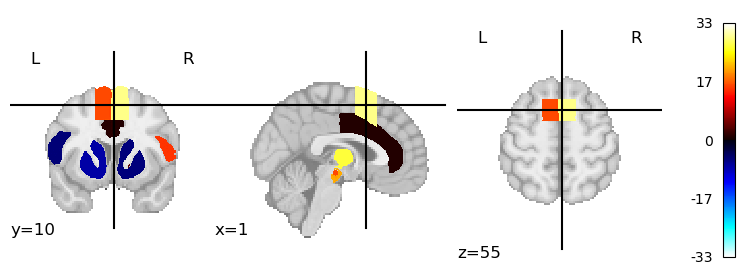

In [16]:
plotting.plot_stat_map(cope)

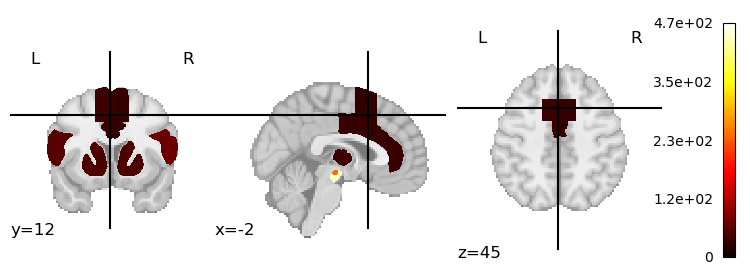

In [17]:
plotting.plot_stat_map(varcope)

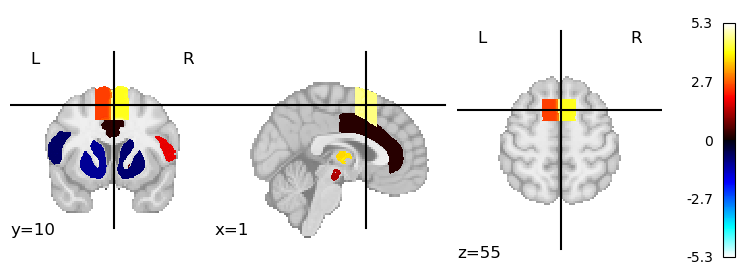

In [18]:
plotting.plot_stat_map(zmap)

# percent signal change?

In [ ]:
nilearn.image.mean_img('')